#                                                                           MODULE A
### NOME: FILIPE DE ORNELAS DIOGO OBRIST
### Nº: 2024170686

# 2. Data loading and visualization:

### 2.1 Create a dictionary with the different classes of the problem as keys (‘forward’, ‘backward’, ‘left’, ‘right’, ‘stop’, ‘_silence_’ and ‘_unknown_’) and the list of the sound filenames of that same class as values.

### 2.2 Analise the number of samples of each class. Is the dataset balanced? If not, what are possible consequences that will be generated if no special action is taken in regard to that unbalance?

In [1]:
# MODULE A

# Make a dictionary with keys: 'forward', 'backward', 'left', 'right', 'stop', '_silence_', '_unknown_'
# The values: List of the sound filenames of that same class as values
import os

# 2.1 Create a dictionary with keys
Commands = {}

for command in ['forward', 'backward', 'left', 'right', 'stop', '_silence_', '_unknown_']:
    Commands[command] = []
    
    for root, dirs, files in os.walk('dataset/' + command):
        for file in files:
            if file.endswith('.wav'):
                Commands[command].append(file)

# 2.2 Compare the number of files in each class
for key in Commands.keys():
    print(key, len(Commands[key]))



forward 1557
backward 1664
left 3801
right 3778
stop 3872
_silence_ 408
_unknown_ 635


NOTE: As we can see by the number of samples for each class, we can see that there is a big difference between the silence, uknown and the rest. This two have way fewer samples. Forward and backward are also a little bit different in this aspect, having half the amount of samples of the rest of the classes.
With this, we can conclude that no, the dataset is not balanced. If no special action is taken in regard to this unbalance, we could have problems like the model being bias towards the class with more samples, or worst identification of the classes with fewer samples, etc. (Mainly overall reduced model performance).

### 2.3 func(filename, class) of a dataset sound, loads it from the file and returns it as a numpy array Note: Normalize the sound before returning it so it is in the range [-1, 1].

In [2]:
# 2.3 func(filename, class) of a dataset sound, loads it from the file and returns it as a numpy array
# Note: Normalize the sound before returning it so it is in the range [-1, 1].
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

def loadSound(filename, class_name):
    # Load the sound
    fs,y = wavfile.read('dataset/' + class_name + '/' + filename)
    # Normalize the sound with the formula professor gave us
    y = y/(abs(np.iinfo(np.int16).min))
    
    
    return fs,y

# Test the function
# Test minimum and maximum values to check if its normalized
fs,y = loadSound(Commands['forward'][0], 'forward')
print(y)
print(np.min(y), np.max(y))





[ 0.00000000e+00 -1.22070312e-04 -9.15527344e-05 ...  7.98034668e-02
  7.30285645e-02  5.71899414e-02]
-0.218780517578125 0.169403076171875


### 2.4 envelope(signal). Returns a signal with the same length as the original sound containing the 'envelope' of the sound. Possible approach is applying a moving average to the absolute value of the signal. Especial care must be taken on the limits of the signal. Use zero padding to avoid boundary effects.

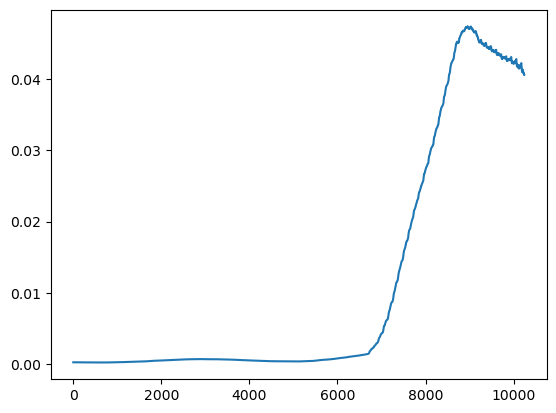

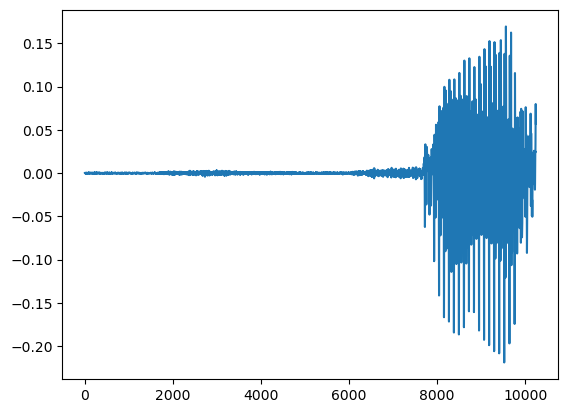

In [3]:
# 2.4 envelope(signal). Returns a signal with the same length as the original sound containing the 'envelope' of the sound.
# Possible approach is applying a moving average to the absolute value of the signal.
# Especial care must be taken on the limits of the signal. Use zero padding to avoid boundary effects.

def envelope(signal, w):
    # For 3.2 to otimize the function
    if w == 1:
        return np.abs(signal)

    # Calculate the envelope
    envelope = np.zeros(len(signal))
    for i in range(len(signal)):
        envelope[i] = np.mean(np.abs(signal[max(0, i-w):min(len(signal), i+w)]))

    return envelope

# Test the function
plt.plot(envelope(y, 999))
plt.show()

plt.plot(y)
plt.show()


## 2.5 func() selects one sample from each class randomly and generates a figure with 7 subplots displaying the sound signal over time. Force the x-axis of all plots to show the time from 0 to 1 second (remember that the sounds have different lengths).

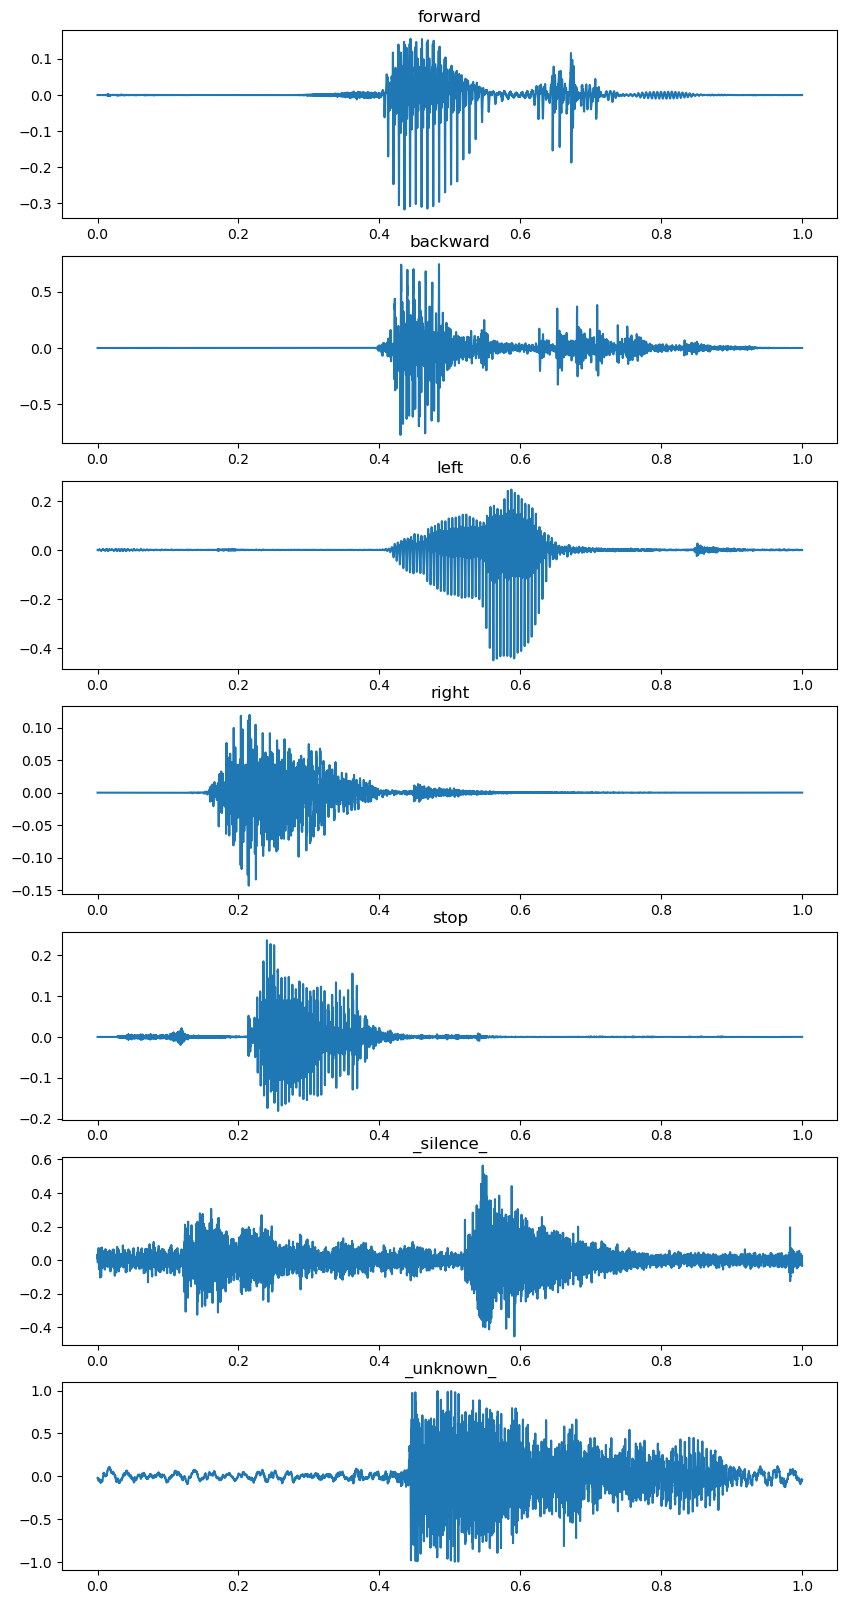

In [4]:
# 2.5 func() selects one sample from each class randomly and generates a figure with 7 subplots displaying the sound signal over time.
# Force the x-axis of all plots to show the time from 0 to 1 second (remember that the sounds have different lengths).

def plotSound():
    fig, axs = plt.subplots(7, 1, figsize=(10, 20))
    for i, key in enumerate(Commands.keys()):
        fs, y = loadSound(Commands[key][np.random.randint(len(Commands[key]))], key)
        axs[i].plot(np.linspace(0, 1, len(y)), y)
        axs[i].set_title(key)

    plt.show()

# Test the function
plotSound()

3. Outliers’ detection: Each sound file has a duration up to 1s, but some might be shorter. To
take a grasp of abnormal sounds, we will analyze the duration of the sounds and the mean
amplitude of its envelope (computed in 2.4).

3.1 Create a function that returns an array with the duration of each sound of a given class.

In [5]:
# 3.1 Create a function that returns an array with the duration of each sound of a given class.
def getDurations(class_name):
    durations = []
    for file in Commands[class_name]:
        fs, y = loadSound(file, class_name)
        durations.append(len(y)/fs)
    return durations

# Test the function
durations = getDurations('stop')
#print(durations)

# For all classes
def getAllDurations():
    durations = {}
    for key in Commands.keys():
        durations[key] = getDurations(key)
    return durations

3.2 Create a function that returns an array with the average amplitude of the
envelope of each sound of a given class.


In [6]:
# 3.2 Create a function that returns an array with the average amplitude of the envelope of each sound of a given class.
def getAmplitudes(className):
    amplitudes = []
    for file in Commands[className]:
        fs, sound = loadSound(file, className)
        envelope_s = envelope(sound, 1)
        amplitudes.append(np.mean(envelope_s))
    return amplitudes

# Test the function
amplitudes = getAmplitudes('stop')
#print(amplitudes)

# For all classes
def getAllAmplitudes():
    amplitudes = {}
    for key in Commands.keys():
        amplitudes[key] = getAmplitudes(key)
    return amplitudes

3.3 Create a function called that given an array of values, a method name (‘iqr’
or ‘zscore’), and any additional parameters needed, returns the outliers’ density
and a list with the indexes of such outliers. Note that the outliers’ density is
calculated by d = (no/nr)*100 where no is the number of elements identified as outliers and nr is the total
number of elements in the array.

In [7]:
# 3.3 Create a function called that given an array of values, a method name (‘iqr’
# or ‘zscore’), and any additional parameters needed, returns the outliers’ density
# and a list with the indexes of such outliers. Note that the outliers’ density is
# calculated by d = (no/nr)*100 where no is the number of elements identified as outliers and nr is the total
# number of elements in the array.

def z_score(data, k):
    mean = data.mean()
    std = data.std()
    z_score = abs((data - mean) / std)
    return data[z_score < k], data[z_score >= k]

def iqr(data, k):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return data[(data >= lower) & (data <= upper)], data[(data < lower) | (data > upper)]

def outliersDensity(data, method, k):
    if method == 'zscore':
        inliers, outliers = z_score(data, k)
    elif method == 'iqr':
        inliers, outliers = iqr(data, k)
    else:
        raise ValueError('Method not supported')
    return len(outliers) / len(data) * 100, outliers

# Test the function
something = np.random.normal(0, 1, 100)
print(outliersDensity(something, 'zscore', 2))
print(outliersDensity(something, 'iqr', 1.5))

(2.0, array([ 1.91223716, -2.35171772]))
(0.0, array([], dtype=float64))


3.4 For each variable (duration and avg_amplitude):

3.4.1. Plot the histogram of the variable for each class

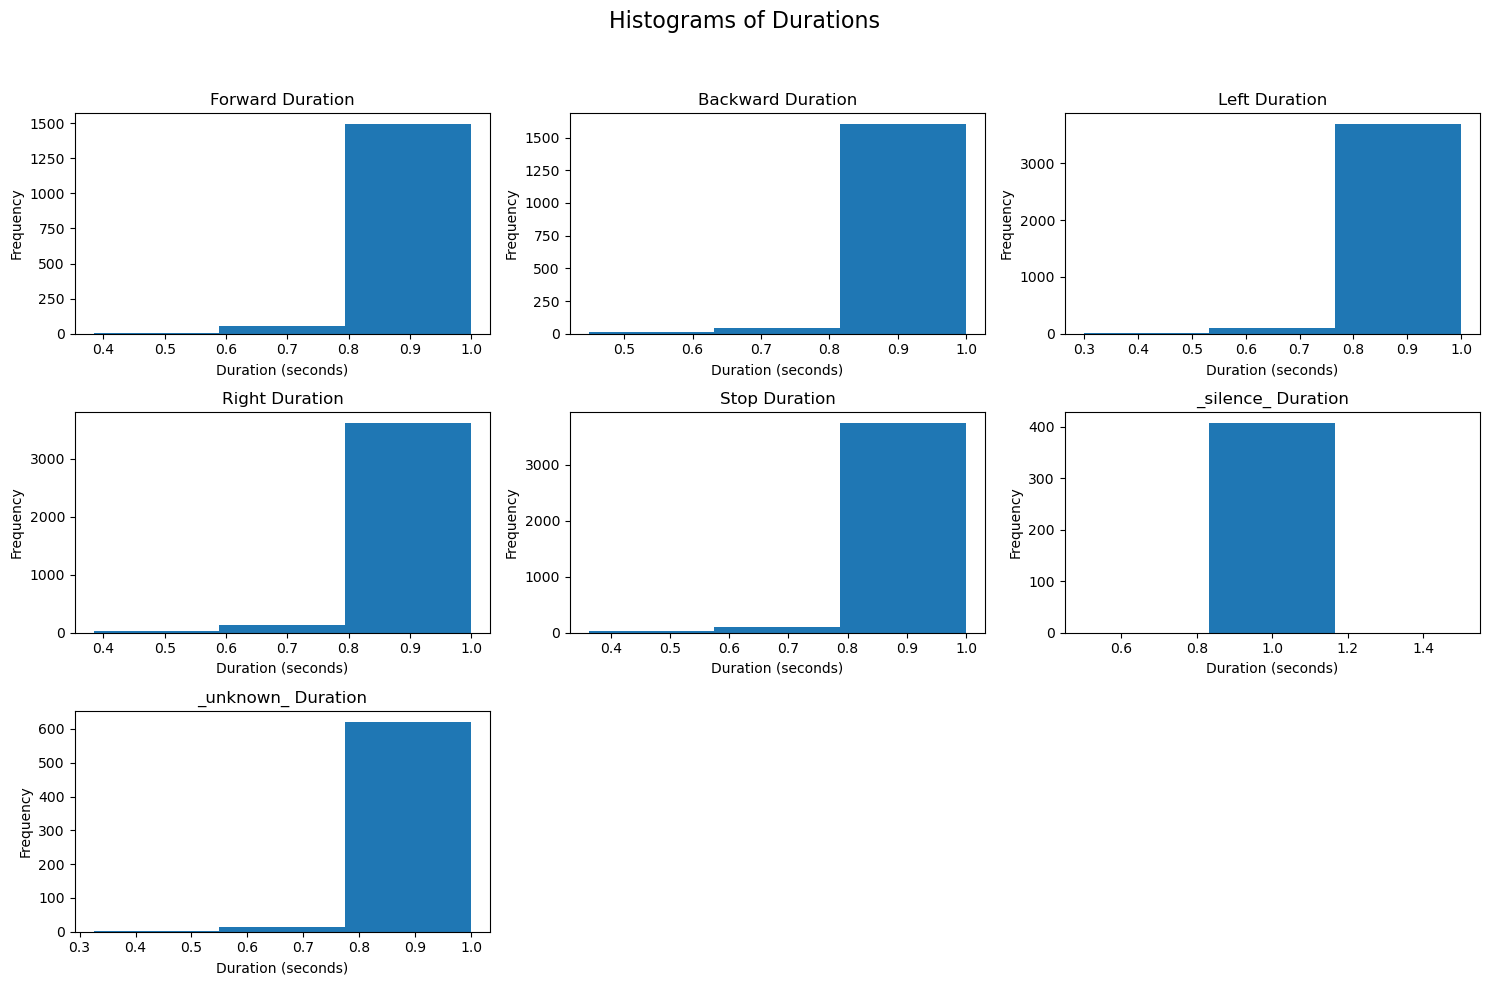

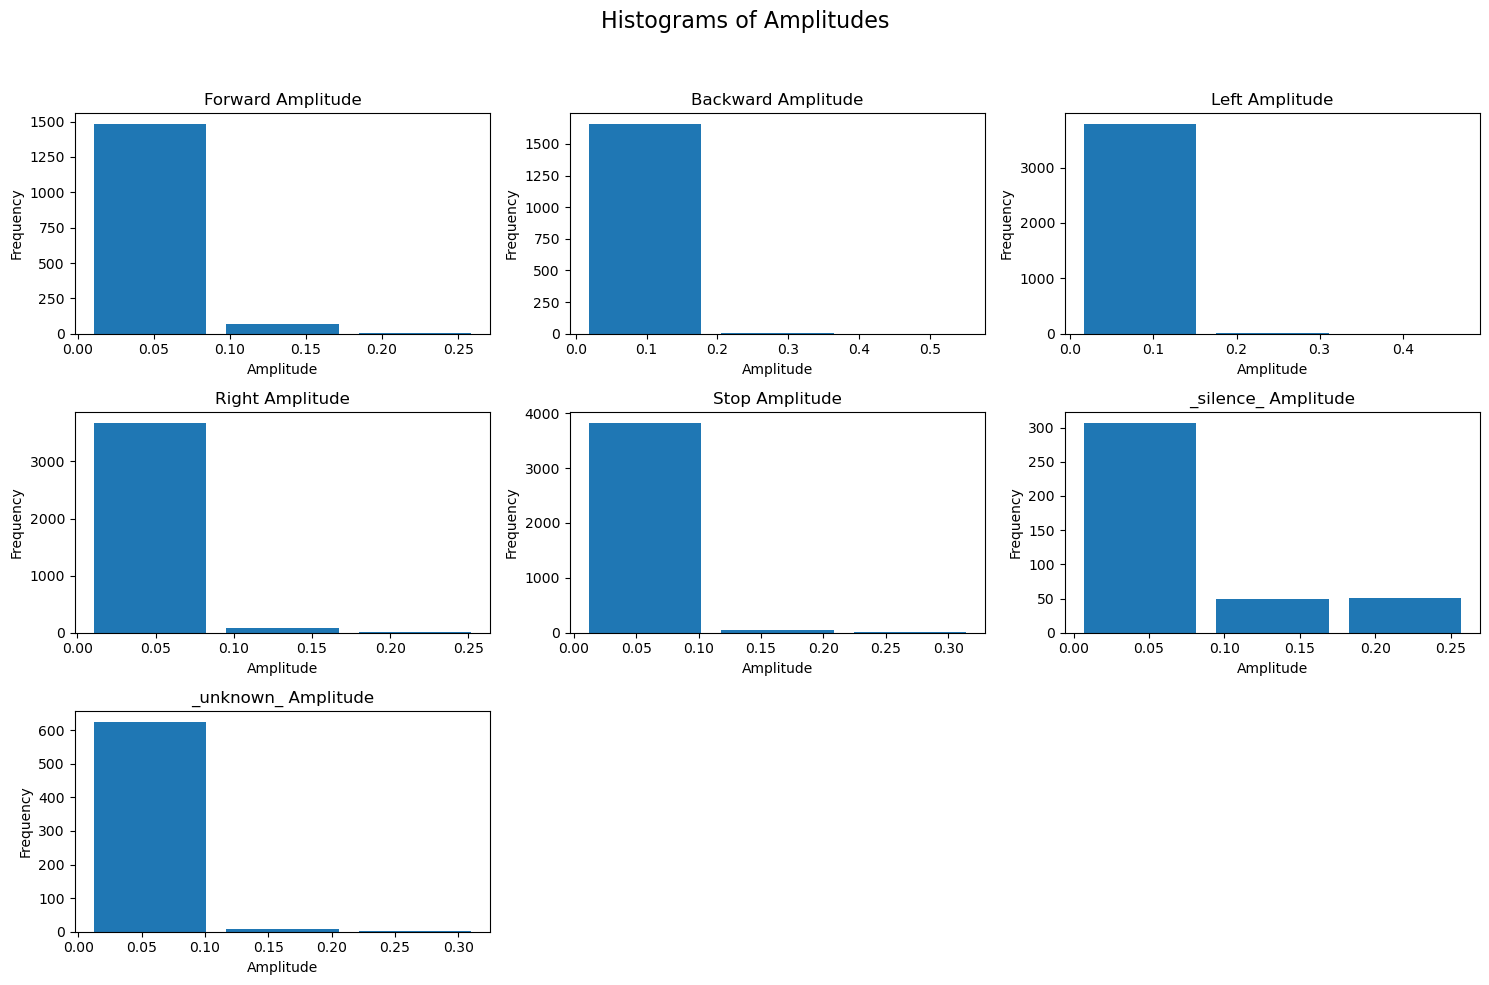

In [8]:
# For each variable (duration and avg_amplitude):
# 3.4.1 Plot the histogram of the variable for each class.

# Duration
def durationHistogram(X):

    # Just some code to configure our plot for a better visualization
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    axs = axs.flatten()

    for i, key in enumerate(X.keys()):
        durations = getDurations(key)
        axs[i].hist(durations, bins=3)
        axs[i].set_title(f'{key.capitalize()} Duration')
        axs[i].set_xlabel('Duration (seconds)')
        axs[i].set_ylabel('Frequency')

    for ax in axs[len(X.keys()):]:
        ax.set_visible(False)

    fig.suptitle(f'Histograms of Durations', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Average Amplitude
from functools import lru_cache

# MY TENTATIVE TO MAKE THIS GO FASTER - IT DIDN'T WORK THAT WELL :/
@lru_cache(maxsize=None)
def getAmplitudesCached(key):
    return getAmplitudes(key)

def amplitudeHistogram(X):
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    axs = axs.flatten()
    
    for i, key in enumerate(X.keys()): 
        amplitudes = getAmplitudesCached(key)  # Use cached version
        # Optionally downsample large data for faster plotting
        # ANOTHER TENTATIVE TO MAKE THIS GO FASTER
        if len(amplitudes) > 10000:  # If dataset is large, downsample
            amplitudes = np.random.choice(amplitudes, size=10000, replace=False)

        axs[i].hist(amplitudes, bins=3, rwidth=0.85)
        axs[i].set_title(f'{key.capitalize()} Amplitude')
        axs[i].set_xlabel('Amplitude')
        axs[i].set_ylabel('Frequency')

    for ax in axs[len(X.keys()):]:
        ax.set_visible(False)

    fig.suptitle(f'Histograms of Amplitudes', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

X = Commands
durationHistogram(X)
amplitudeHistogram(X)

3.4.2 Make a scatter plot where all points for each class are present, with
the outliers showing with a different color 

C:\Users\PC\AppData\Local\Temp\ipykernel_3808\2145431648.py:10: RuntimeWarning: invalid value encountered in divide
  z_score = abs((data - mean) / std)


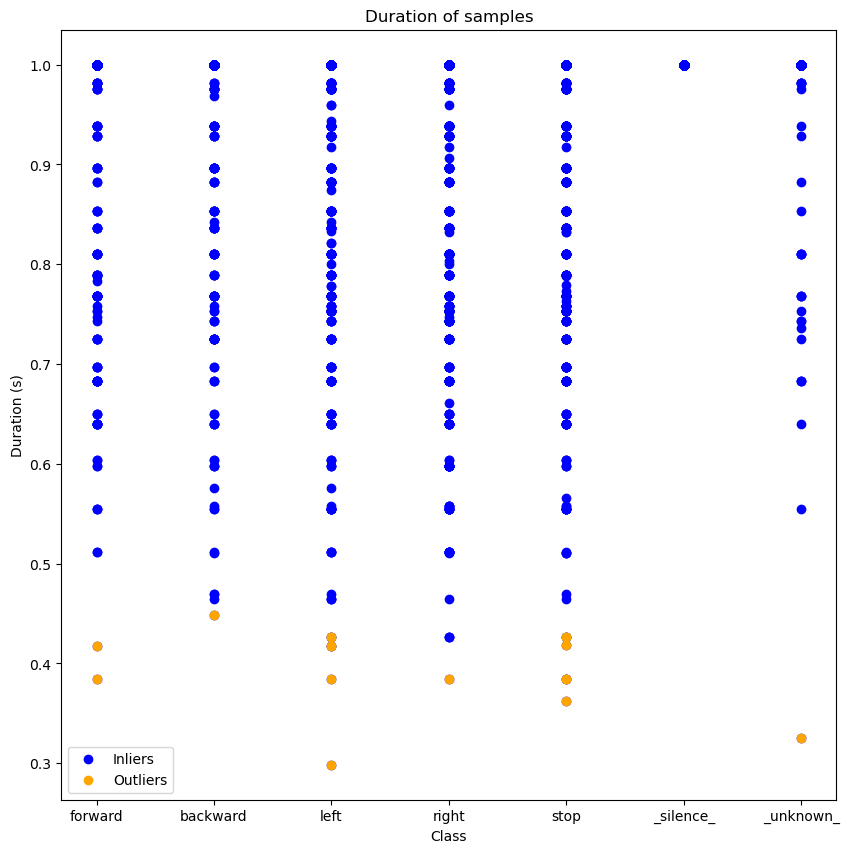

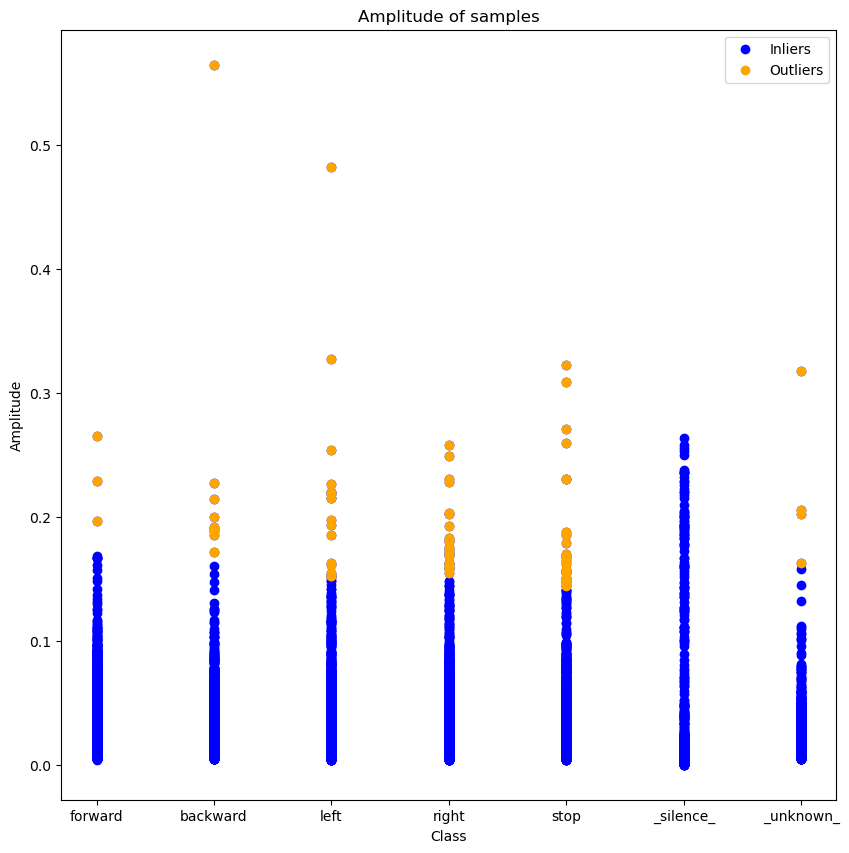

In [9]:
# 3.4.2 Make a scatter plot where all points for each class are present, with
# the outliers showing with a different color.

# Duration
def scatterDuration(X):
    # put all classes in a single plot. They all have same color (blue), and the outliers are orange
    fig, ax = plt.subplots(figsize=(10, 10))
    for key in X.keys():
        durations = getDurations(key)
        _, outliers = outliersDensity(np.array(durations), 'zscore', 8.5)
        # If the point is an outlier, plot it in orange
        ax.scatter([key] * len(durations), durations, color='blue')
        ax.scatter([key] * len(outliers), outliers, color='orange')
    ax.set_xlabel('Class')
    ax.set_ylabel('Duration (s)')
    ax.set_title('Duration of samples')
    plt.legend(['Inliers', 'Outliers'])
    plt.show()

# Test the function
X = Commands
scatterDuration(X)

# Average Amplitude
def scatterAmplitude(X):
    # put all classes in a single plot. They all have same color (blue), and the outliers are orange
    fig, ax = plt.subplots(figsize=(10, 10))
    for key in X.keys():
        amplitudes = getAmplitudesCached(key)
        not_used, outliers = outliersDensity(np.array(amplitudes), 'zscore', 5) # Test with 3, 3.5, 4...
        # If the point is an outlier, plot it in orange
        ax.scatter([key] * len(amplitudes), amplitudes, color='blue')
        ax.scatter([key] * len(outliers), outliers, color='orange')
    ax.set_xlabel('Class')
    ax.set_ylabel('Amplitude')
    ax.set_title('Amplitude of samples')
    plt.legend(['Inliers', 'Outliers'])
    plt.show()

# Test the function
scatterAmplitude(X)


### Multivariate Approach

- For this part, the duration and avg_amplitude will be considered together to
identify the outliers


3.5 Create a function that implements the K-MEANS for a given number of
clusters (input parameter)

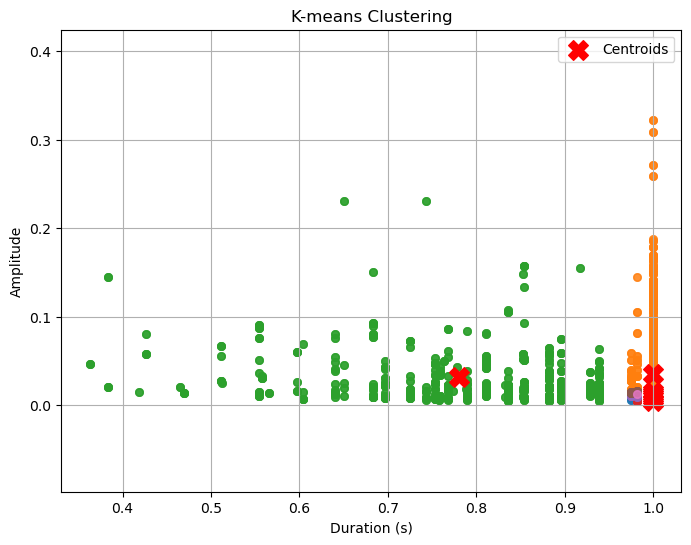

Converged after 31 iterations.


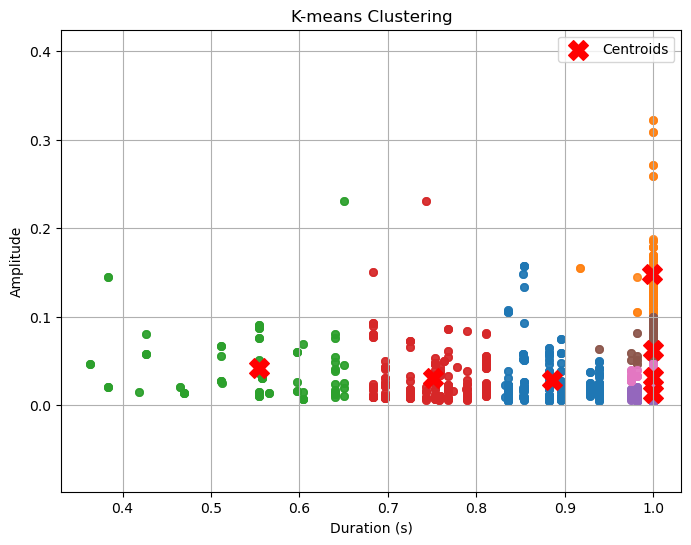

In [10]:
# For this part, the duration and avg_amplitude will be considered together to
# identify the outliers
# 3.5 Create a function that implements the K-MEANS for a given number of
# clusters (input parameter)


# IMPLEMENTATION FOLLOWING THE SLIDES
def kmeans(X, k, max_iters=100):
    # Step 1: Randomly initialize k centroids from the data points
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    

    def plotClusters(X, centroids, labels):
        plt.figure(figsize=(8, 6))
        
        # Plot each cluster
        for i in range(len(centroids)):
            points = X[labels == i]
            if len(points) == 0:
                continue  # Skip empty clusters
            plt.scatter(points[:, 0], points[:, 1], s=30, alpha=0.6)
        
        # Plot centroids in red with larger markers
        plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X', label='Centroids')
        
        # Customizing the plot
        plt.title('K-means Clustering')
        plt.xlabel('Duration (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()

    # Here we use max_iters to avoid infinite loops in case of non-convergence
    for i in range(max_iters):
        # Step 2: Assign each point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Step 3: Recompute the centroids as the mean of the points in each cluster (Update)
        temp_centroids = np.zeros_like(centroids)
        for j in range(k):
            if len(X[labels == j]) > 0:
                temp_centroids[j] = X[labels == j].mean(axis=0)
            else:
                temp_centroids[j] = centroids[j]

        

        # Step 4: Check for convergence (if centroids don't change)
        if np.array_equal(centroids , temp_centroids):
            break
        
        centroids = temp_centroids

        if i == max_iters - 1:
            print("Maximum number of iterations reached. Consider increasing max_iters.")

        # Visualize the first iteration
        if i == 0:
            plotClusters(X, centroids, labels)
        
    # Visualize the final state
    print(f"Converged after {i + 1} iterations.")
    plotClusters(X, centroids, labels)

    return centroids, labels

# THIS IS A TEST CLASS BY CLASS
# Test the function with our data
# durations = getDurations('_unknown_')
# amplitudes = getAmplitudes('_unknown_')
# X = np.array(list(zip(durations, amplitudes)))
# k = 3  # Number of clusters
# centroids, labels = kmeans(X, k)

# As the teacher said, we will now plot all classes together, with k=7
all_durations = getAllDurations()
all_amplitudes = getAllAmplitudes()
X = np.array([[durations[i], amplitudes[i]] for key in all_durations.keys() for i in range(len(all_durations[key]))])
k = 7  # Number of clusters
centroids, labels = kmeans(X, k)

3.6 Analyze the outliers of the dataset using the k-means (each sample is now
characterized by the two variables). Try several numbers of clusters. Make 2D
plots to illustrate the results

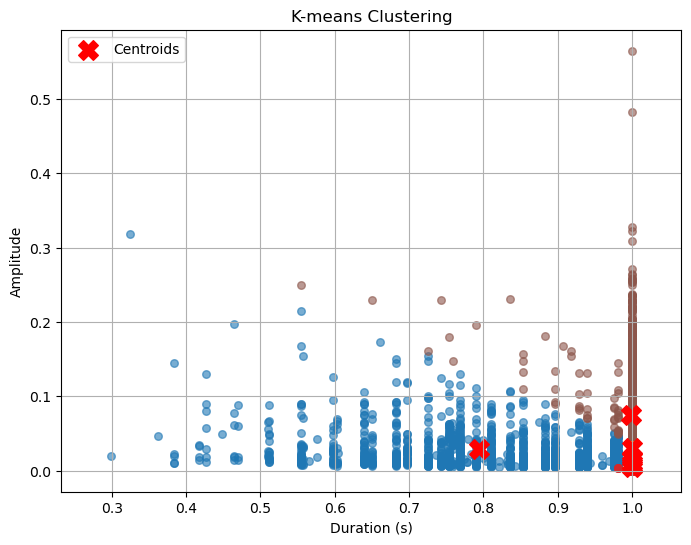

Converged after 76 iterations.


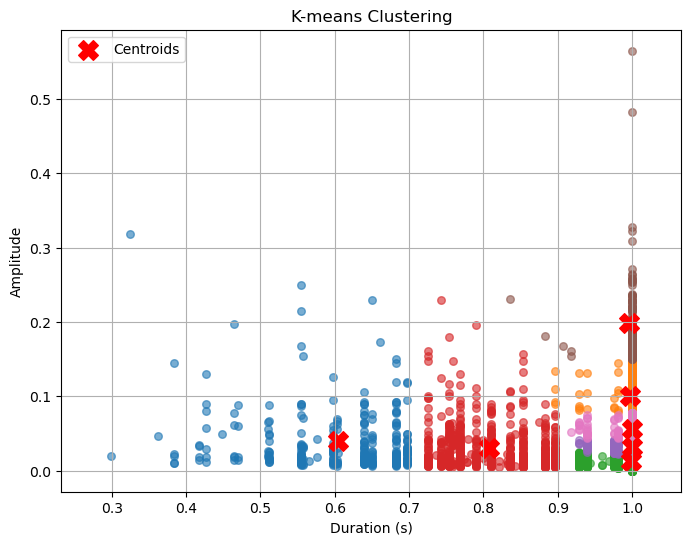

Found 48 outliers out of 15715 points (0.31%).


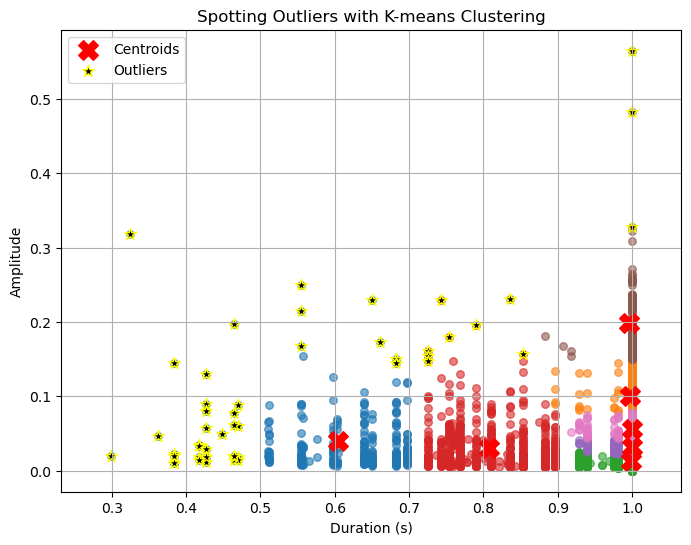

In [11]:
# 3.6 Analyze the outliers of the dataset using the k-means (each sample is nowcharacterized by the two variables). 
# Try several numbers of clusters. Make 2D plots to illustrate the results

# Analyze outliers using K-Means

# Function to analyze and visualize outliers using the K-means function
def analyzeOutliersWithKmeans(X, k, threshold_percentile=95, max_iters=100):
    centroids, labels = kmeans(X, k, max_iters=max_iters)
    
    #Calculate the distance of each point to its assigned centroid
    distances = np.linalg.norm(X - centroids[labels], axis=1)
    
    #Identify outliers by checking the distances 
    threshold = np.percentile(distances, threshold_percentile)
    outliers = X[distances > threshold]

    print(f'Found {len(outliers)} outliers out of {len(X)} points ({len(outliers) / len(X) * 100:.2f}%).')

    # Lets plot everything so we can analyze the results
    plotOutliersClusters(X, centroids, labels, outliers)

# Function to plot clusters and highlight outliers
def plotOutliersClusters(X, centroids, labels, outliers):
    plt.figure(figsize=(8, 6))

    # Plot each cluster
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=30, alpha=0.6)
    
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X', label='Centroids')

    # Highlight outliers
    if len(outliers) > 0:
        plt.scatter(outliers[:, 0], outliers[:, 1], s=75, c='black', marker='*', edgecolors='yellow', label='Outliers')

    # Customizing the plot
    plt.title('Spotting Outliers with K-means Clustering')
    plt.xlabel('Duration (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


# Trying to understand the outliers and compare the results with the ones in 3.4
# durations = getDurations('forward')
# amplitudes = getAmplitudes('forward')
# X = np.array(list(zip(durations, amplitudes)))

# Since we will need to compare the results with the ones in 3.4, we will plot all the classes together
X = np.array([[all_durations[key][i], all_amplitudes[key][i]] for key in all_durations.keys() for i in range(len(all_durations[key]))])
k = 7  # Number of clusters
# threshold_percentile = 95 -> 5% of the furthest points will be considered outliers
analyzeOutliersWithKmeans(X, k, threshold_percentile=99.7, max_iters=100)


    

### 3.7 Compare the results of 3.6 with the results of 3.4. Comment the differences (if any).

To compare this results may be a little more complex, since K-means is a multivariate approach that considers both features (amplitude and duration) to
detect outliers, while z-score/iqr are univariate approaches that consider the features separately. Also, while K-means identifies outliers based on their distance 
from clusters, z-score and iqr focus on deviations from the mean. 
Despite all this, with the right number of clusters and the right threshold percentile, the results seem quite similar. If you take a look at the results of the previous exercices, we can see that the outliers detected are almost equal in both cases (being that in 3.4 we have the features separated). If we compare the marks in the amplitude, we can see that in the univariate approach, when the amplitudes marks a little bit lower than 0.2 the points start to be considered outliers, except in one class. This is also notible in the approach where we used kmeans. If we also compare in the duration perspective, it all seems in order aswell, since in the interval [0.0, 0.45] all points are considered outliers in both approaches.

##### 3.7.1. Bonus: make a similar study using the DBSCAN algorithm (we suggest the use of sklearn1 library) 


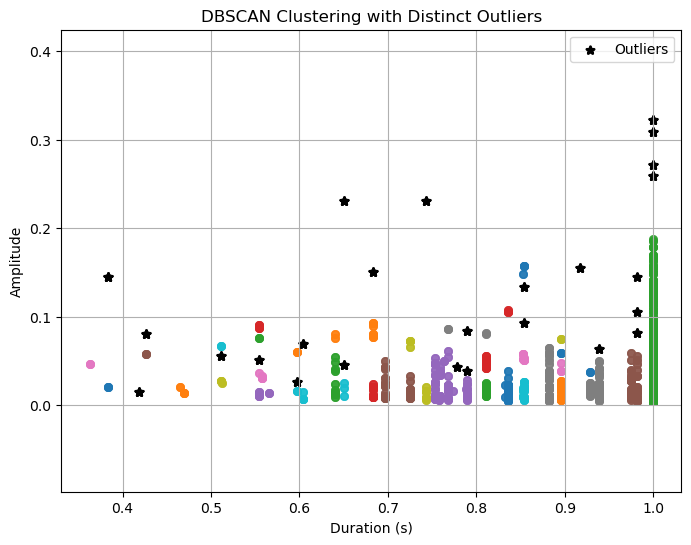

In [12]:
from sklearn.cluster import DBSCAN

# Function to apply DBSCAN and visualize the results
def analyze_outliers_dbscan(X, eps=0.5, min_samples=5):
    # Apply DBSCAN algorithm
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    # Identify outliers (points labeled as -1)
    outliers = X[labels == -1]

    # Lets plot it so we can compare
    plot_dbscan_clusters(X, labels, outliers)

# Function to plot clusters and highlight outliers distinctly
def plot_dbscan_clusters(X, labels, outliers):
    unique_labels = set(labels)
    plt.figure(figsize=(8, 6))
    
    # Plot each cluster
    for label in unique_labels:
        if label == -1:
            # Skip outliers for now
            continue
        cluster_points = X[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=30, alpha=0.6)
    
    # Lets make them black stars this time just to be different
    if len(outliers) > 0:
        plt.scatter(outliers[:, 0], outliers[:, 1], s=30, c='black', marker='*', linewidths=2, label='Outliers')

    # Customize plot
    plt.title('DBSCAN Clustering with Distinct Outliers')
    plt.xlabel('Duration (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


# Test the function
X = np.array([[durations[i], amplitudes[i]] for key in all_durations.keys() for i in range(len(all_durations[key]))])
analyze_outliers_dbscan(X, eps=0.01, min_samples=5)  # Adjust eps


NOTE: Way more clusters. The outliers are a little bit different and in my opinion, a little bit more wrongly marked. It doesnt look like a good approach to me for our case at least, or maybe i just did it incorrectly.

## 4. Data imputation: In this section, we will artificially inject outliers in the dataset and evaluate our capacity to recover those values with a linear model.

4.1. For this exercise, we will create a miniature dataset. Let us consider only
the first 200 songs of each class. For each song, we will use the envelope of
the song (as implemented in 2.4) and downsample it with a factor of 100 (for
each 100 data points of the envelope, we will keep only the first one and
discard the remaining 99). Then, we will concatenate all the sounds within
each class in one single unidimensional array.

In [13]:
# 4.1. For this exercise, we will create a miniature dataset. Let us consider only the first 200 songs of each class. For each song, we will use the envelope of
# the song (as implemented in 2.4) and downsample it with a factor of 100 (for each 100 data points of the envelope, we will keep only the first one and
# discard the remaining 99). Then, we will concatenate all the sounds within each class in one single unidimensional array.

# Creating the miniature dataset
minidataset = {}
originals = {}
downsampled = {}

for key in Commands.keys():
    minidataset[key] = []
    originals[key] = 0
    downsampled[key] = 0
    
    # Process up to 200 songs for each class, and thats it
    n_songs = min(200, len(Commands[key]))
    
    for i in range(n_songs):
        # Load the sound for each song
        fs, y = loadSound(Commands[key][i], key)
        envelope_y = envelope(y, 1)
        
        originals[key] += len(envelope_y)
        
        # Downsample by keeping only every 100th data point
        downsampled_y = envelope_y[::100]
        downsampled[key] += len(downsampled_y)
        
        # Append the downsampled
        minidataset[key].append(downsampled_y)

# Concatenate all the downsampled songs within each class into a single array
minidataset_concatenated = {}
for key in minidataset.keys():
    minidataset_concatenated[key] = np.concatenate(minidataset[key])

# Lets compare the number of samples before and after downsampling
for key in minidataset_concatenated.keys():
    print(f"Class {key}:")
    print(f"  Original number of samples: {originals[key]}")
    print(f"  Downsampled number of samples: {downsampled[key]}")







Class forward:
  Original number of samples: 3153804
  Downsampled number of samples: 31546
Class backward:
  Original number of samples: 3142238
  Downsampled number of samples: 31432
Class left:
  Original number of samples: 3166875
  Downsampled number of samples: 31675
Class right:
  Original number of samples: 3153480
  Downsampled number of samples: 31545
Class stop:
  Original number of samples: 3138606
  Downsampled number of samples: 31400
Class _silence_:
  Original number of samples: 3200000
  Downsampled number of samples: 32000
Class _unknown_:
  Original number of samples: 3122593
  Downsampled number of samples: 31238


4.2. Create a function that injects x% of outliers in a given array. Select randomly x% of the elements of the array and 
update their value to 1.5 (since the envelope of the song is contained in the range [0, 1], the points will become outliers). 

Density of outliers in the original data: {'forward': 2.529639256958093, 'backward': 2.357470094171545, 'left': 2.0142067876874505, 'right': 2.1207798383262007, 'stop': 2.035031847133758, '_silence_': 2.65, '_unknown_': 2.256866636788527}
Density of outliers in the outlier-injected data: {'forward': 2.9987954098776393, 'backward': 3.0064902010689742, 'left': 3.201262825572218, 'right': 3.1225233792994134, 'stop': 3.111464968152866, '_silence_': 3.009375, '_unknown_': 3.066777642614764}


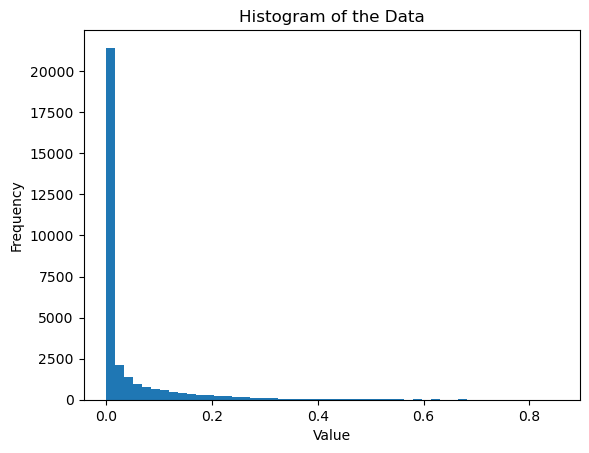

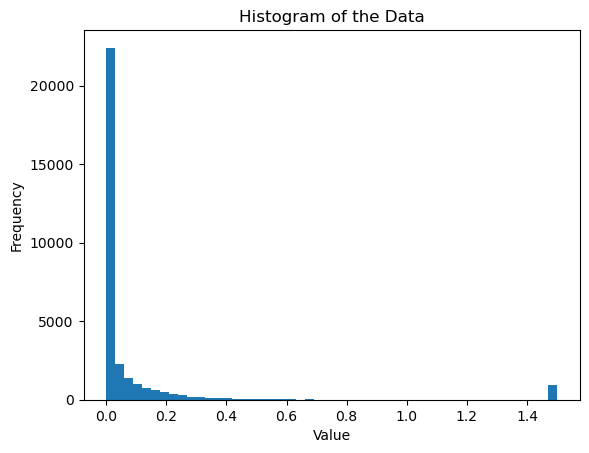

In [14]:
# 4.2. Create a function that injects x% of outliers in a given array. Select randomly x% of the elements of the array and 
# update their value to 1.5 (since the envelope of the song is contained in the range [0, 1], the points will become outliers). 

# Function to inject outliers
def injectOutliers(data, percentage):
    data = data.copy()

    # number of outliers to inject
    n_outliers = int(len(data) * percentage / 100)
    
    # lets make a random selection as the enunciate asks
    indices = np.random.choice(len(data), size=n_outliers, replace=False)
    data[indices] = 1.5
    
    return data, indices

# 4.2.1. Inject 3% of outliers in each class and visualize them with the methods developed in 3.3 and 3.4.
X = minidataset_concatenated
percentage = 3  # Inject 3% outliers

noisy_data = {}
outliers = {}

# Injecting outliers
for key in X:
    noisy_data[key], outliers[key] = injectOutliers(X[key], percentage)

# Calculate the density of outliers in the original and outlier-injected data
original_outliers = {}
injected_outliers = {}

for key in X:
    original_outliers[key], not_used = outliersDensity(X[key], 'zscore', 3)
    injected_outliers[key], not_used = outliersDensity(noisy_data[key], 'zscore', 3)

# Compare the density of outliers in the original and outlier-injected data
print("Density of outliers in the original data:", original_outliers)
print("Density of outliers in the outlier-injected data:", injected_outliers)

# Plot the histograms of the original and outlier-injected data
def histogram(arr):
    plt.hist(arr, bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of the Data')
    plt.show()

histogram(X['forward'])
histogram(noisy_data['forward'])






4.3. We will now try to recover the original values using a linear model of order
p. Create a function that receives n training samples of vectors with size p,
meaning (xi,1, xi,2, xi,2, ... , xi,p) and the corresponding output yi.

4.4. Find the linear model for each class using the sample dataset (see 4.1),
considering p values before each sample. Then, use it to compute new values
for replacing the outliers injected in 4.2.1. Analyze your prediction error
showing i) the error distribution for each class and ii) Plots showing the
original envelope and the one with the predicted values. Find the best p for
your model.

4.5. Repeat 4.4 using a window of order p centered in the instant to predict.
Compare with the results obtained in 4.4.

In [15]:
# 4.3. We will now try to recover the original values using a linear model of order p. Create a function that receives n training samples of vectors with size p,
# meaning (xi,1, xi,2, xi,2, ... , xi,p) and the corresponding output yi.

# Simplified linear regression function
def linearRegression(noisy_data, p):
    Y = noisy_data[p:]
    X = np.array([np.concatenate(([1], noisy_data[i-p:i])) for i in range(p, len(noisy_data))])
    
    # Calculate beta
    beta = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, Y))
    
    return beta

#Test the function
p = 25  # definir p
beta = linearRegression(noisy_data['forward'], p)

# 4.5
p_centered = 20  # definir p
beta_centered = linearRegression(noisy_data['forward'], p)


# 4.4. Find the linear model for each class using the sample dataset (see 4.1),
# considering p values before each sample. Then, use it to compute new values
# for replacing the outliers injected in 4.2.1. Analyze your prediction error
# showing i) the error distribution for each class and ii) Plots showing the
# original envelope and the one with the predicted values. Find the best p for
# your model 

# First, lets use our beta to predict the values of the outliers
# we will do beta * X, where X is the matrix of the p previous values of the outlier
# we will do this for each outlier in the dataset and replace the outlier with the predicted value
# Function to analyze prediction error and plot results

original = np.copy(minidataset_concatenated['forward'])
predicted = np.copy(minidataset_concatenated['forward'])
predicted_4_5 = np.copy(minidataset_concatenated['forward'])
errors = {}
errors_4_5 = {}

for idx in outliers['forward']:
        if idx >= p:  # Ensure we have p previous values
                # We must  predict the value by doing beta * X, where X is the matrix of the p previous values of the outlier
                X = np.concatenate(([1], predicted[idx-p:idx]))
                predicted_value = sum(beta[i] * X[i] for i in range(len(beta)))

                # 4.5) Same as before, but now we multiply beta by p/2 before and p/2 after values of the outlier so that our p is centered in the outlier
                X_4_5 = np.concatenate(([1], predicted_4_5[idx-p//2:idx+p//2]))

                # We mmust see if there is more than p/2 values after the outlier
                if len(X_4_5) < len(beta_centered):
                    X_4_5 = np.concatenate(([1], predicted_4_5[idx-p_centered:idx+p_centered]))
                predicted_value_4_5 = sum(beta_centered[i] * X_4_5[i] for i in range(len(beta_centered)))

                # Replace the outlier with the predicted value
                predicted[idx] = predicted_value
                errors[idx] = original[idx] - predicted[idx]

                predicted_4_5[idx] = predicted_value_4_5
                errors_4_5[idx] = original[idx] - predicted_4_5[idx]


        # Plot the original point in blue and predicted point in red
        # plt.scatter(idx, original[idx], color='blue', label='Original' if idx == outliers['forward'][0] else "")
        # plt.scatter(idx, predicted[idx], color='red', label='Predicted' if idx == outliers['forward'][0] else "")

# Calculate the mean squared error
mse = np.mean([error**2 for error in errors.values()])
print(f"Mean Squared Error: {mse}")


# 4.5)
mse = np.mean([error**2 for error in errors_4_5.values()])
print(f"Mean Squared Error when window centered in the instant: {mse}")

# plt.title('Original vs. Predicted Values for Outliers')
# plt.xlabel('Index')
# plt.ylabel('Value')

# # Add legend once
# plt.legend(loc='upper right')
# plt.show()






Mean Squared Error: 0.005281182202600166
Mean Squared Error when window centered in the instant: 0.004832659163630415


## 5. Feature extraction: the main goal of this section is extracting characteristic information with discrimination power that a classification system can efficiently use.

5.1. Write a small state-of-the-art on features used for sound classification. Cite
your sources. Select and justify a set of those features to implement. 

After some research, I found this article where i think it explained really well each feature. After doing some cross-checking, i confirmed that the features 
presented in this article wear state-of-the-art features used for sound classification. I will enumerate the features discussed in the article and also mark the ones
im going to implement.

1. Statistical Features: A first easy step is to compute the mean, standard deviation, minimum, maximum, median and quartiles of the frequencies of each signal. This can be done using Numpy and it always brings value to our feature extraction. This kind of approach can be used in gender recognition for example, as seen on Kaggle.

2. Energy: The energy of a signal is the total magnitude of the signal, i.e. how loud the signal is. What i want to do is to implement an Energy Entropy feature

3. Root Mean Square Energy:The RMS Energy (RMSE) is simply the square root of the mean squared amplitude over a time window. I will implement this feature

4. Zero-Crossing Rate: The zero crossing rate indicates the number of times that a signal crosses the horizontal axis, i.e. the number of times that the amplitude reaches 0.
5. Tempo: An estimate of the tempo in Beats Per Minute (BPM).

6. Mel Frequency Cepstral Coefficients (MFCC): In this ones the author bases on other article (http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/). The MFCC are state-of-the-art features for speaker identification, disease detection, speech recognition, and by far the most used among all features present in this article. This are ones of the features that I seak to implement.

7. Mel Frequency Cepstral Differential Coefficients: MFCC lacks information on the evolution of the coefficients between frames. What we can therefore do is to compute the 12 trajectories of the MFC coefficients and append them to the 12 original coefficients. This highly improves results on ASR tasks. I will also being implementing this features.


8. Polyfeatures: The polyfeatures returns the coefficients of fitting an nth-order polynomial to the columns of a spectrogram. This can be easily extracted using Librosa.
9. Tempogram: The tempo, measured in Beats Per Minute (BPM) measures the rate of the musical beat. The tempogram is a feature matrix which indicates the prevalence of certain tempi at each moment in time. Librosa has a built-in function to extract this information.

10. Spectal Features: Spectral features are extracted from the spectrogram. Spectrograms offer a powerful representation of the data. It plots over the time, for a given range of frequencies, the power (dB) of a signal. This allows us to spot periodic patterns over time, and regions of activity.
I will try to implement some spectral features. 

(...)

https://maelfabien.github.io/machinelearning/Speech9/#4-zero-crossing-rate

Implemented Features:

MFCCs: I will apply this feature because MFCCs are a staple in speech and sound classification due to their ability to represent the spectral properties of sound, which are critical for distinguishing between different commands. These coefficients are particularly good at capturing the timbre and phonetic information in sounds, making them highly effective for speech-like commands such as "forward" or "left". Are widely regarded as essential features in speech recognition and sound classification tasks due to their biologically inspired emphasis on the frequencies most important for human perception

RMS Energy: Gives insight into the loudness of a signal over time. This is essential in our context, as louder sounds might correlate with different command nuances, or they may serve as a distinguishing factor between background noise and intentional command sounds. Is commonly applied in sound analysis and has been effective in capturing variations in amplitude, which can help with distinguishing sound types, especially when combined with other spectral features.

Energy Entroypy: Measures the unpredictability or complexity of the energy distribution within a sound. Higher entropy values indicate more varied energy, which can help separate complex sounds like background noise from more structured commands. Is useful in speech and audio analysis tasks for noise and event detection, providing a measure of sound stability that complements other spectral and temporal features.

Spectral Centroid: Represents the "center of mass" of the spectrum, giving us an idea of where the majority of the sound’s energy is concentrated. This is relevant for distinguishing different sound qualities, as it reflects the brightness of a sound—important for differentiating between various spoken commands. Is a common feature in audio processing that helps classify sounds based on perceived brightness, making it useful in distinguishing voice characteristics in commands.

Spectral Bandwidth: Quantifies the range of frequencies within a signal. Commands may vary in frequency range, and this feature helps capture the spread of these frequencies, aiding in differentiating between distinct sound profiles, such as commands versus ambient sounds. Is widely used to quantify the frequency range within sound signals and is particularly helpful in characterizing sounds with distinct frequency patterns.

MFCDC: Track the changes in MFCCs over time, which is valuable for recognizing patterns in commands spoken with varying speed or emphasis. By capturing the rate of change, MFCC delta coefficients add a dynamic perspective to the MFCCs, enhancing the model’s ability to handle variability in command delivery. Delta features have shown to improve speech recognition models by adding temporal dynamics to static MFCCs, making them especially useful in speech and command-based applications.

These features collectively provide a robust representation of both the spectral and temporal properties of sound. For our project, these selected features are anticipated to handle the nuances of wheelchair commands effectively. The combination of MFCCs and spectral features like centroid and bandwidth offers spectral depth, while RMS energy and energy entropy provide insights into sound amplitude and complexity. The MFCC delta coefficients add temporal adaptability, crucial for handling natural variations in command input.

5.2. Create a function that extracts those features from a sound. You must end
up with more than 25 features per sound. One option to have more features
is to segment the sound into different parts (first 200ms, 200ms-400ms, etc)
and extract features for each part

In [16]:
import librosa
import os

# Function to extract features from a single audio file
def extractFeatures(audio_path, sample_rate=16000):

    # Just in case the file does not exist
    if not os.path.isfile(audio_path):
        print(f"Error: File {audio_path} does not exist.")
        return None

    try:
        y, sr = librosa.load(audio_path, sr=sample_rate)

    # One more precaution in case of any error    
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None

    features = []

        
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(mfccs.mean(axis=1))

    # RMS Energy
    rms_energy = librosa.feature.rms(y=y)
    features.append(rms_energy.mean())

    # Energy Entropy
    energy_entropy = -np.sum(rms_energy * np.log2(rms_energy + 1e-10))
    features.append(energy_entropy)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(spectral_centroid.mean())

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features.append(spectral_bandwidth.mean())

    # Mel Frequency Cepstral Differential Coefficients
    mfcc_delta = librosa.feature.delta(mfccs)
    features.extend(mfcc_delta.mean(axis=1))


    return np.array(features)

# Function to iterate over all classes and files to generate feature_data and classes
def allFeaturesByClass(Commands):
    feature_data = []
    classes = []

    for label, files in Commands.items():
        for file_path in files:
            # Extract features for each file
            features = extractFeatures("dataset" + f"/{label}/" + file_path)
            #print(len(features)) # We have approximately 30 features per sound. NOTE: THIS IS NOT A CONSTANT VALUE. ITS CONSTANTLY CHANGING BECAUSE IM CHANGING THE FEATURES.
            if features is not None:
                feature_data.append(features)
                classes.append(label)  # Assign class label for each file

    return feature_data, classes

# Example usage with Commands dictionary
# Commands = {
#     "forward": ["dataset/forward/0a2b400e_nohash_0.wav", ...],
#     "left": ["dataset/left/1b2c300f_nohash_0.wav", ...],
#     # Other classes and their respective files
# }

feature_data, classes = allFeaturesByClass(Commands)
#print(classes)


dict_keys(['forward', 'backward', 'left', 'right', 'stop', '_silence_', '_unknown_'])
Number of samples: 15715
Number of features per sample: 30


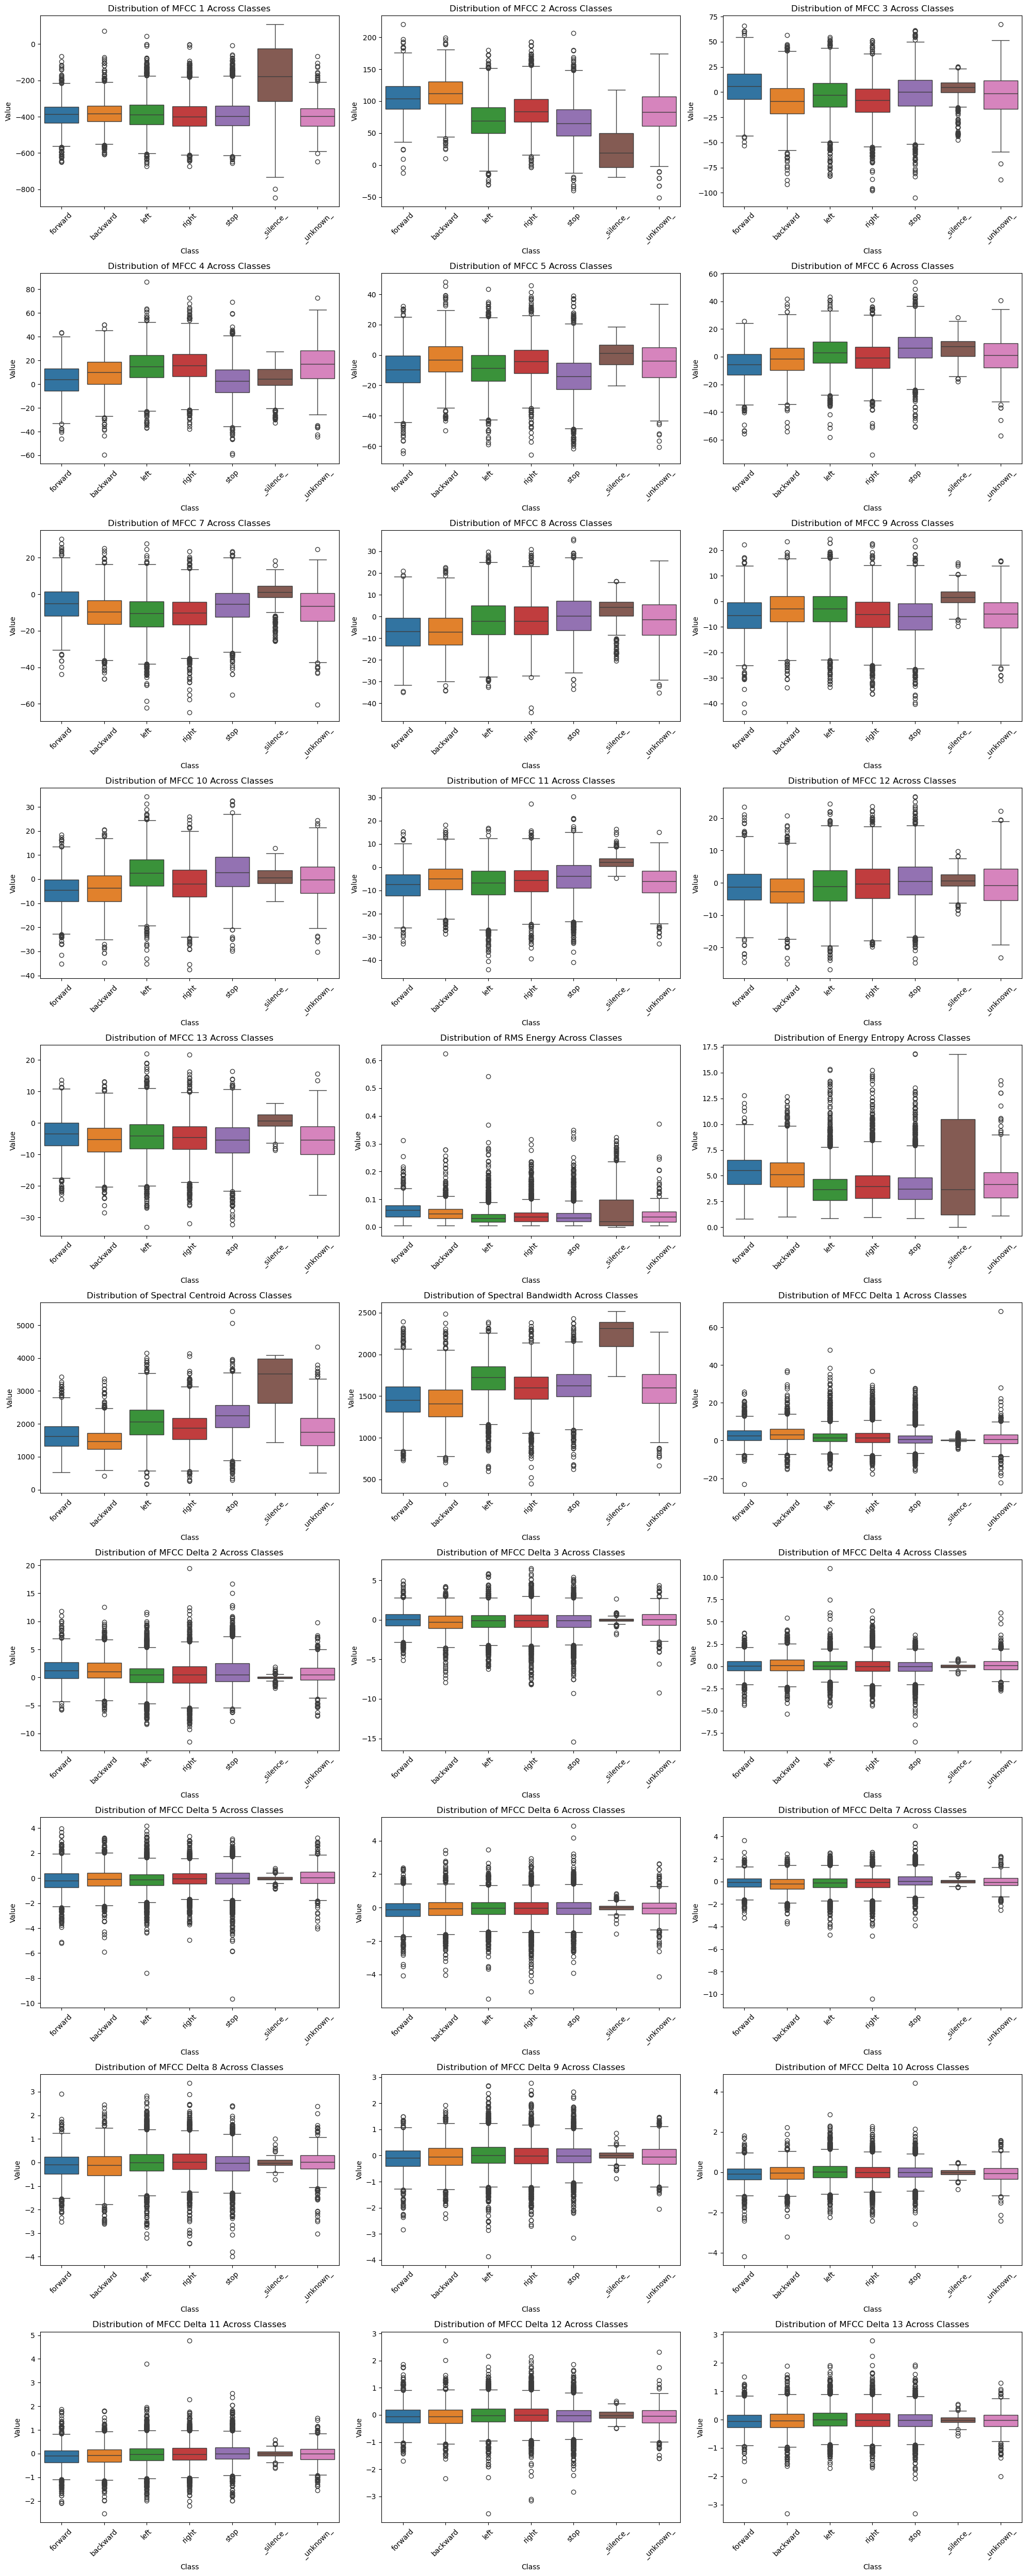

In [17]:
import pandas as pd
import seaborn as sns

# create a dict with the feature_data and classes to better organization
dict_features = {}
for i in range(len(classes)):
    if classes[i] not in dict_features:
        dict_features[classes[i]] = []
    dict_features[classes[i]].append(feature_data[i])

print(dict_features.keys())
print("Number of samples:", len(feature_data))
print("Number of features per sample:", len(feature_data[5]))

# to better vizualization when we will see how the features are distributed.
# Flatten the data to create a DataFrame suitable for plotting
flattened_data = []
for label, features in dict_features.items():
    for feature_vector in features:
        for i, value in enumerate(feature_vector):
            flattened_data.append({"Feature": f"Feature {i+1}", "Value": value, "Class": label})

# Convert to a DataFrame for easy plotting with seaborn
df = pd.DataFrame(flattened_data)

# Get the list of unique feature names
unique_features = df["Feature"].unique()


num_features = len(unique_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

feature_names = {
    0: "MFCC 1", 1: "MFCC 2", 2: "MFCC 3", 3: "MFCC 4", 4: "MFCC 5", 5: "MFCC 6", 6: "MFCC 7", 7: "MFCC 8",
    8: "MFCC 9", 9: "MFCC 10", 10: "MFCC 11", 11: "MFCC 12", 12: "MFCC 13", 13: "RMS Energy",
    14: "Energy Entropy", 15: "Spectral Centroid", 16: "Spectral Bandwidth", 17: "MFCC Delta 1",
    18: "MFCC Delta 2", 19: "MFCC Delta 3", 20: "MFCC Delta 4", 21: "MFCC Delta 5", 22: "MFCC Delta 6",
    23: "MFCC Delta 7", 24: "MFCC Delta 8", 25: "MFCC Delta 9", 26: "MFCC Delta 10", 27: "MFCC Delta 11",
    28: "MFCC Delta 12", 29: "MFCC Delta 13"
}

# Loop through each feature to create a subplot
for i, feature in enumerate(unique_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x="Class", y="Value", data=df[df["Feature"] == feature], hue="Class", legend=False)
    plt.title(f"Distribution of {feature_names[i]} Across Classes")
    plt.xticks(rotation=45)

# Adjust layout for readability
plt.tight_layout()
plt.show()


5.3. Create a function that, given a variable/feature, finds its statistical power in
discriminating between the classes of the problem. Start by checking the normality of its 
distribution and then select the correct test to apply. To select the right test, we suggest you to check the reference:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2881615/.

5.3.1. Justify the choice(s) of the test(s).

I choose Shapiro-Wilk to test the distribution of each feature in each class. This test is recommended when we have smaller/more moderate sample size. It also tests the features independently for each class. After testing if its normal or not-normal, we have two possible tests: IF normal, we test with ANOVA, if not we use Kruskal.
Basing myself on the paper, ANOVA is recommended for comparing multiple groups, as it has high power to detect mean differences when assumptions are met (normality and homogeneity of variances). Kruskal is a non-parametric and robust alternative to ANOVA when the data is not normal. Its very effective to compare the distribution of multiple independent groups without relying on normality.  

5.3.2. Rank your feature set by statistical significance. Present them
in a table showing the feature name, the result of the normality
assessment, the name of the test applied, and its result

In [18]:
import scipy.stats as stats
import pandas as pd

# Function to calculate the statistical power of a single feature across classes
def discriminativePower(dict_features, feature_idx, alpha=0.05):
    # Separate the feature data by class for the given feature index
    classes = list(dict_features.keys())
    grouped_data = [np.array([features[feature_idx] for features in dict_features[label]]) for label in classes]
    normality = ""

    # Step 1: Check normality for each class using Shapiro-Wilk test
    normal = True
    for data in grouped_data:
        stat, p = stats.shapiro(data)
        if p < alpha:
            normal = False
            break

    # Step 2: Select the appropriate test based on normality
    if normal:
        # If normal, use ANOVA
        stat, p_value = stats.f_oneway(*grouped_data)
        test_name = "ANOVA"
        normality = "Normal"
        
        
    else:
        # If non-normal, use Kruskal-Wallis test
        stat, p_value = stats.kruskal(*grouped_data)
        test_name = "Kruskal-Wallis"
        normality = "Non-Normal"
        

    return test_name, p_value, normality

# Initialize a list to store each row of the table
results = []

# Table for 5.3.2
for feature_idx in range(len(feature_data[0])):
    test_name, p_value, normality = discriminativePower(dict_features, feature_idx)

    feature_names = {
    0: "MFCC 1", 1: "MFCC 2", 2: "MFCC 3", 3: "MFCC 4", 4: "MFCC 5", 5: "MFCC 6", 6: "MFCC 7", 7: "MFCC 8",
    8: "MFCC 9", 9: "MFCC 10", 10: "MFCC 11", 11: "MFCC 12", 12: "MFCC 13", 13: "RMS Energy",
    14: "Energy Entropy", 15: "Spectral Centroid", 16: "Spectral Bandwidth", 17: "MFCC Delta 1",
    18: "MFCC Delta 2", 19: "MFCC Delta 3", 20: "MFCC Delta 4", 21: "MFCC Delta 5", 22: "MFCC Delta 6",
    23: "MFCC Delta 7", 24: "MFCC Delta 8", 25: "MFCC Delta 9", 26: "MFCC Delta 10", 27: "MFCC Delta 11",
    28: "MFCC Delta 12", 29: "MFCC Delta 13"
    }

    feature_name = feature_names.get(feature_idx, "Unknown Feature")




    # Append the result as a dictionary for easy DataFrame conversion
    results.append({
        "Feature": feature_name,
        "Normality": normality,
        "Test": test_name,
        "P-Value": p_value,
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results).sort_values(by="P-Value").reset_index(drop=True)

# Print the table
print("Exercise 5.3.2 - Ranked Feature Set by Statistical Significance")
print(results_df)



Exercise 5.3.2 - Ranked Feature Set by Statistical Significance
               Feature   Normality            Test        P-Value
0               MFCC 2  Non-Normal  Kruskal-Wallis   0.000000e+00
1               MFCC 4  Non-Normal  Kruskal-Wallis   0.000000e+00
2               MFCC 5  Non-Normal  Kruskal-Wallis   0.000000e+00
3               MFCC 6  Non-Normal  Kruskal-Wallis   0.000000e+00
4              MFCC 10  Non-Normal  Kruskal-Wallis   0.000000e+00
5   Spectral Bandwidth  Non-Normal  Kruskal-Wallis   0.000000e+00
6    Spectral Centroid  Non-Normal  Kruskal-Wallis   0.000000e+00
7       Energy Entropy  Non-Normal  Kruskal-Wallis  1.388583e-284
8               MFCC 8  Non-Normal  Kruskal-Wallis  3.186628e-247
9               MFCC 7  Non-Normal  Kruskal-Wallis  6.144101e-237
10          RMS Energy  Non-Normal  Kruskal-Wallis  1.229435e-227
11             MFCC 11  Non-Normal  Kruskal-Wallis  3.842229e-209
12              MFCC 3  Non-Normal  Kruskal-Wallis  3.438698e-183
13        MF

## 6. Feature transformation and selection: the main goal of this section is to reduce the space of the problem by transforming the feature space into a smaller space while retaining most of its discriminative power.

6.1. Develop the code needed to implement a Principal Component Analysis to
the feature set.

6.1.1. Determine the importance of each vector in explaining the
variability of the feature space. Note that you should normalize
the features using the z-score. How many transformed variables
should you use to explain 75% of the feature set?

In [19]:
# 6.1.1. Determine the importance of each vector in explaining the
# variability of the feature space. Note that you should normalize
# the features using the z-score. How many transformed variables
# should you use to explain 75% of the feature set?
# NOTE: We will always create a new variable so we dont change our original feature data.

from scipy import stats

# Normalize function
def normalize(feature_data):
    return stats.zscore(feature_data), np.mean(feature_data, axis=0), np.std(feature_data, axis=0)

# Covariance function
def covariance(data):
    return np.cov(data, rowvar=False)

# PCA function
def pca(feature_data, variance_threshold=0.75):
    # Normalize the data
    normalized_data, mean, std = normalize(feature_data)

    covariance_matrix = covariance(normalized_data)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort everything
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Calculate explained variances
    explained_variances = sorted_eigenvalues / np.sum(sorted_eigenvalues)

    cumulative_variance = np.cumsum(explained_variances)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1 # +1 because of 0-indexing, we want the number of components

    # top n_components eigenvectors
    best_components = sorted_eigenvectors[:, :n_components]

    return best_components, n_components, explained_variances, cumulative_variance


# Perform PCA to determine the number of components to explain 75% of the variance
best_components, n_components, explained_variances, cumulative_variance = pca(feature_data, variance_threshold=0.75)

# Lets print some stuff
print(f"Number of transformed variables to explain 75% of the feature set: {n_components}")
print(f"Explained variances for each component: {explained_variances}")
print(f"Cumulative variance explained: {cumulative_variance}")


Number of transformed variables to explain 75% of the feature set: 15
Explained variances for each component: [0.11247912 0.09849752 0.08421302 0.07457133 0.05076882 0.04630142
 0.03989459 0.03878882 0.03452705 0.03344673 0.03140446 0.0309801
 0.0295304  0.02725762 0.02624688 0.02594805 0.02415201 0.02336004
 0.02293536 0.02204863 0.02145433 0.01969468 0.01753668 0.01727651
 0.01647099 0.01191019 0.00741819 0.00538416 0.00310043 0.00240187]
Cumulative variance explained: [0.11247912 0.21097664 0.29518967 0.36976099 0.42052981 0.46683124
 0.50672583 0.54551465 0.5800417  0.61348843 0.64489289 0.67587299
 0.70540339 0.73266101 0.75890789 0.78485594 0.80900795 0.83236799
 0.85530335 0.87735198 0.89880631 0.91850099 0.93603767 0.95331418
 0.96978517 0.98169535 0.98911355 0.99449771 0.99759813 1.        ]


6.1.2. Transform the feature set.

In [20]:
# 6.1.2. Transform the feature set.
# Transform the feature set
feature_data_normalized, mean, std = normalize(feature_data)
best_components, n_components, explained_variances, cumulative_variance = pca(feature_data)

feature_transformed = np.dot(feature_data_normalized, best_components)


# Print the shape of the transformed features
print(f"Shape of transformed features: {feature_transformed.shape}")

# Lets print the names of the features that we will use
print("Features used:")
for i in range(n_components):
    print(f"{feature_names[i]}")

Shape of transformed features: (15715, 15)
Features used:
MFCC 1
MFCC 2
MFCC 3
MFCC 4
MFCC 5
MFCC 6
MFCC 7
MFCC 8
MFCC 9
MFCC 10
MFCC 11
MFCC 12
MFCC 13
RMS Energy
Energy Entropy


6.1.3. Create a function that, given the features of a new sound,
applies the same PCA transformation to it (uses the weights
computed with the dataset) and returns only the transformed
variables corresponding to the first 75% of the variance explained

In [21]:
# 6.1.3. Create a function that, given the features of a new sound,
# applies the same PCA transformation to it (uses the weights
# computed with the dataset) and returns only the transformed
# variables corresponding to the first 75% of the variance explained.

# Function to apply PCA transformation
def pcaTransformation(new_features, best_components):
    # Normalize the new features
    new_features_normalized = stats.zscore(new_features.reshape(1, -1), axis=1)

    # Transform using precomputed PCA components
    transformed_new_features = np.dot(new_features_normalized, best_components)
    
    return transformed_new_features

# Test the function with a new sound
new_sound_features = extractFeatures("dataset/forward/0a2b400e_nohash_0.wav")
#print(new_sound_features)

# KEEP IN MIND: We are using the best_components that we calculated before. This best_components is the one that explains 75% of the variance FOR THIS DATASET!!
transformed_new_features = pcaTransformation(new_sound_features, best_components)

# Print the shape of the transformed new features
print(f"Shape of new features: {new_sound_features.shape}")
print(f"Shape of transformed new features: {transformed_new_features.shape}")


Shape of new features: (30,)
Shape of transformed new features: (1, 15)


6.2. Implement the Fisher Score and ReliefF methods.

6.2.1. Identify the top 10 features using each of those methods.
Comment on the differences between the two approaches.

In [22]:
# 6.2. Implement the Fisher Score and ReliefF methods.
# 6.2.1. Identify the top 10 features using each of those methods.
# Comment on the differences between the two approaches.

from sklearn.metrics import pairwise_distances

# Function to calculate the Fisher Score for each feature
def fisher_score(feature_data, classes):
    # Separate the feature data by class
    classes_unique = np.unique(classes)
    grouped_data = [np.array([features for features, label in zip(feature_data, classes) if label == class_label]) for class_label in classes_unique]

    # Calculate the mean and standard deviation for each feature in each class
    means = [np.mean(group, axis=0) for group in grouped_data]
    std_devs = [np.std(group, axis=0) for group in grouped_data]

    # Calculate the Fisher Score for each feature
    fisher_scores = []
    for i in range(len(feature_data[0])):
        score = sum((means[j][i] - means[k][i])**2 / (std_devs[j][i]**2 + std_devs[k][i]**2) for j in range(len(classes_unique)) for k in range(j+1, len(classes_unique)))
        fisher_scores.append(score)

    return fisher_scores

# Calculate the Fisher Score for each feature
fisher_scores = fisher_score(feature_data, classes)

# Sort the Fisher Scores in descending order
sorted_indices = np.argsort(fisher_scores)[::-1]
top_10_fisher_scores = [(i, fisher_scores[i]) for i in sorted_indices[:10]]
print("Top 10 features using Fisher Score:")
for i, score in top_10_fisher_scores:
    print(f"{feature_names[i]}: {score:.4f}")


# Function to calculate the ReliefF score for each feature
def reliefF(feature_data, classes, k=10):
    n_samples, n_features = feature_data.shape
    relief_scores = np.zeros(n_features)
    
    # Calculate pairwise distances
    distances = pairwise_distances(feature_data, feature_data)
    
    # Iterate through each sample
    for i in range(n_samples):
        # Get label and distances for the current instance
        current_label = classes[i]
        distances_i = distances[i]
        
        # Find k nearest hits and misses
        same_class_idx = np.where(classes == current_label)[0]
        diff_class_idx = np.where(classes != current_label)[0]
        
        nearest_hits = same_class_idx[np.argsort(distances_i[same_class_idx])[1:k+1]]
        nearest_misses = diff_class_idx[np.argsort(distances_i[diff_class_idx])[:k]]
        
        # Update relief scores
        for j in range(n_features):
            relief_scores[j] -= np.sum((feature_data[i, j] - feature_data[nearest_hits, j])**2) / (k * n_samples)
            relief_scores[j] += np.sum((feature_data[i, j] - feature_data[nearest_misses, j])**2) / (k * n_samples)

    return relief_scores

# Calculate the ReliefF scores for each feature
relief_scores = reliefF(np.array(feature_data), np.array(classes))

# Sort the ReliefF scores in descending order and get the top 10 features
sorted_indices_relief = np.argsort(relief_scores)[::-1]
top_10_relief_scores = [(i, relief_scores[i]) for i in sorted_indices_relief[:10]]
print("\nTop 10 features using ReliefF:")
for i, score in top_10_relief_scores:
    print(f"{feature_names[i]}: {score:.4f}")


Top 10 features using Fisher Score:
Spectral Bandwidth: 36.1566
Spectral Centroid: 22.0599
MFCC 2: 20.6836
MFCC 11: 7.7205
MFCC 1: 4.6557
MFCC 13: 4.5977
MFCC 4: 3.9684
MFCC 9: 3.9210
MFCC 8: 3.6892
MFCC 7: 3.5365

Top 10 features using ReliefF:
MFCC 1: 140.7581
MFCC 4: 25.3941
MFCC 7: 22.2363
MFCC 6: 13.7652
MFCC 3: 12.0338
MFCC 10: 10.1564
MFCC 11: 9.4865
MFCC 8: 5.9933
MFCC 13: 2.8424
MFCC Delta 1: 2.4602


COMPARISSONS: Fisher Score clearly relies more on class-wise means and variances to identify features that maximize separation between classes in terms of mean difference. In this rank, we can se that the spectral features have higher scores. This is a consequence of what we see in the plots we did in 5.2, where we can see clearly that these are the features that have more differences in the mean between classes.
As for the ReliefF ranking, the focus is more measuring each feature's contribution to distinguish individual samples between classes, focusing on local feature relevance.  

6.2.2. Transform the feature set.

In [23]:
# 6.2.2 Transform the features set.

# Combine top features from Fisher Score and ReliefF
top_fisher_indices = [i for i, _ in top_10_fisher_scores]
top_relief_indices = [i for i, _ in top_10_relief_scores]

# Transform the feature data by selecting only the chosen features
transformed_features_fisher = np.array(feature_data)[:, top_fisher_indices]
transformed_features_relief = np.array(feature_data)[:, top_relief_indices]

# Print the names of selected features for reference
print("\nSelected features using Fisher Score:")
for i in top_fisher_indices:
    print(f"{feature_names[i]}")

print("Transformed feature set shape:" , transformed_features_fisher.shape)

print("\nSelected features using ReliefF:")
for i in top_relief_indices:
    print(f"{feature_names[i]}")

print("Transformed feature set shape:" , transformed_features_relief.shape)



Selected features using Fisher Score:
Spectral Bandwidth
Spectral Centroid
MFCC 2
MFCC 11
MFCC 1
MFCC 13
MFCC 4
MFCC 9
MFCC 8
MFCC 7
Transformed feature set shape: (15715, 10)

Selected features using ReliefF:
MFCC 1
MFCC 4
MFCC 7
MFCC 6
MFCC 3
MFCC 10
MFCC 11
MFCC 8
MFCC 13
MFCC Delta 1
Transformed feature set shape: (15715, 10)


6.2.3. Create a function that, given the features of a new sound,
returns only the top 10 features based on the Fisher Score or the
ReliefF method

In [24]:
# List of feature names, assuming they correspond to indices in the feature arrays
feature_names = [
    "MFCC 1", "MFCC 2", "MFCC 3", "MFCC 4", "MFCC 5", "MFCC 6", "MFCC 7", "MFCC 8",
    "MFCC 9", "MFCC 10", "MFCC 11", "MFCC 12", "MFCC 13", "RMS Energy", "Energy Entropy",
    "Spectral Centroid", "Spectral Bandwidth", "MFCC Delta 1", "MFCC Delta 2", "MFCC Delta 3",
    "MFCC Delta 4", "MFCC Delta 5", "MFCC Delta 6", "MFCC Delta 7", "MFCC Delta 8",
    "MFCC Delta 9", "MFCC Delta 10", "MFCC Delta 11", "MFCC Delta 12", "MFCC Delta 13"
]

# Function to get the top 10 features based on Fisher Score or ReliefF
def getTopFeatures(new_sound_features, feature_data, classes, method="fisher"):
    # Compute feature scores based on the selected method
    if method == "fisher":
        scores = fisher_score(feature_data, classes)
    elif method == "relief":
        scores = reliefF(feature_data, classes)
    else:
        raise ValueError("Method should be either 'fisher' or 'relief'")

    # Get indices of the top 10 features based on the scores
    top10 = np.argsort(scores)[-10:][::-1]  # Sort and select top 10

    # also return all feature sorted by score
    sorted_indices = np.argsort(scores)[::-1]
    all_features_sorted = {feature_names[i]: scores[i] for i in sorted_indices}

    # Extract the selected top 10 feature names and values for the new sound
    top_feature_names = [feature_names[i] for i in top10]
    top_feature_values = new_sound_features[top10]

    # top10 features scores
    top_feature_scores = {feature_names[i]: scores[i] for i in top10}
    
    # Return both the feature and scores
    return list(zip(top_feature_names, top_feature_values)), top_feature_scores, all_features_sorted

# Test the function with the new sound features
top_fisher_features, fisher_scores, _ = getTopFeatures(new_sound_features, np.array(feature_data), np.array(classes), method="fisher")
top_relief_features, relief_scores, _ = getTopFeatures(new_sound_features, np.array(feature_data), np.array(classes), method="relief")


# Print the top 10 features based on Fisher Score and ReliefF
print("Top 10 Features based on Fisher Score:")
for name, score in fisher_scores.items():
    print(f"{name}: {score:.4f}")

print("\nTop 10 Features based on ReliefF:")
for name, score in relief_scores.items():
    print(f"{name}: {score:.4f}")




Top 10 Features based on Fisher Score:
Spectral Bandwidth: 36.1566
Spectral Centroid: 22.0599
MFCC 2: 20.6836
MFCC 11: 7.7205
MFCC 1: 4.6557
MFCC 13: 4.5977
MFCC 4: 3.9684
MFCC 9: 3.9210
MFCC 8: 3.6892
MFCC 7: 3.5365

Top 10 Features based on ReliefF:
MFCC 1: 140.7581
MFCC 4: 25.3941
MFCC 7: 22.2363
MFCC 6: 13.7652
MFCC 3: 12.0338
MFCC 10: 10.1564
MFCC 11: 9.4865
MFCC 8: 5.9933
MFCC 13: 2.8424
MFCC Delta 1: 2.4602


6.3. Discuss the differences, advantages, and disadvantages of the approaches used
in points 6.1 and 6.2.

In this section, we have implemented two approaches for feature transformation: Principal Component Analysis (PCA) in 6.1 and Fisher Score and ReliefF methods in 6.2

PCA is basically an unsupervised dimensionality reduction by selecting components that account for 75% of the variance. By retaining components with the highest variance, PCA captures only the most significant patterns in the data. However, it may induce loss of interpretability since the transformed components are linear combinations of the original features, and it also ignores class information, wich can lead to retaining features that explain variance but are less relevant to class separation. For this project, for example, PCA may capture background sound variations irrelevant to command differentiation.

Then, We have Fisher Score and ReliefF. This ones are supervised feature selections designed to select the most discriminative features directly, i.e, they maximize class separation. While Fisher Score ranks features based on how well they separate the means of each class relative to whithin-class variance, ReliedF considers local difference between samples by looking at nearest hits (equal class) and misses (different class) for each sample, making it sensitive to instance-level distinctions. In both cases, we select actual features rather than transformations. 

In this project, i believe Fisher Score and ReliefF are more suitable because we not only have class labels avaiable but we also want interpretable, discriminative features. With this methods we can select features that directly support command differentiation, wich is one of the main focus of this project.



# Module B
### Implementation and Evaluation of Machine Learning Models for Voice Command Classification for Wheelchair Control Using Python, NumPy, SciPy, and Scikit-learn

## 1. Data splitting and performance metrics.
### 1.1. Data Splitting. Using the scikit-learn library, implement functions for data splitting considering three approaches:
#### 1.1.1.Train-Test (TT) split. See information in: TT_split
#### 1.1.2.Train-Validation-Test (TVT) split. Use nested TT split.
#### 1.1.3.K-Fold Cross-Validation. See information in: scikitlearn_KFold.
##### Note: Consider stratified data splitting. The functions must receive as input arguments the features, the labels, and the necessary indications for data splitting.

In [83]:
# 1.1. Data Splitting. Using the scikit-learn library, implement functions for data splitting considering three approaches:
#    1.1.1.Train-Test (TT) split. See information in: TT_split
#   1.1.2.Train-Validation-Test (TVT) split. Use nested TT split.
#   1.1.3.K-Fold Cross-Validation. See information in: scikitlearn_KFold.
#   Note: Consider stratified data splitting. The functions must receive as input arguments the
#   features, the labels, and the necessary indications for data splitting.

from sklearn.model_selection import train_test_split, StratifiedKFold

# Train Test Split
def TT_Split(features, labels, train_size=0.7):    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=train_size, shuffle=True, stratify=labels)
    
    return X_train, X_test, y_train, y_test

# Train Validation Test Split (Nested Train-Test Split)
def TVT_Split(features, labels, train_size=0.4 , validation_size=0.3):
    # First split the data into Train-Test
    train_size_v1 = train_size + validation_size
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=train_size_v1, shuffle=True, stratify=labels)
    
    # Then split the training data into Train-Validation
    train_size = train_size / train_size_v1
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_size, shuffle=True, stratify=y_train)
    
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# K-Fold Cross-Validation
def KFold_CrossValidation(features, labels, n_splits=5):
    # Initialize the KFold object
    kf = StratifiedKFold(n_splits=n_splits, shuffle=False)
    folds = kf.split(features, labels)
    fold_indices = []

    for train_idx, test_idx in folds:
        fold_indices.append((train_idx, test_idx))

    # returns the indices of the training and test sets for each fold in a list of tuples (train_idx, test_idx)
    return fold_indices

# TESTE
X_train, X_test, y_train, y_test = TT_Split(feature_data, classes)
print("Testing Train-Test Split")
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

X_train, X_val, X_test, y_train, y_val, y_test = TVT_Split(feature_data, classes)
print("\nTesting Train-Validation-Test Split")
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

print("\nTesting K-Fold Cross-Validation")
fold_indices = KFold_CrossValidation(np.array(feature_data), np.array(classes))
for i, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"Fold {i+1}: Train size: {len(train_idx)}, Test size: {len(test_idx)}")


Testing Train-Test Split
Train size: 11000
Test size: 4715

Testing Train-Validation-Test Split
Train size: 6285
Validation size: 4715
Test size: 4715

Testing K-Fold Cross-Validation
Fold 1: Train size: 12572, Test size: 3143
Fold 2: Train size: 12572, Test size: 3143
Fold 3: Train size: 12572, Test size: 3143
Fold 4: Train size: 12572, Test size: 3143
Fold 5: Train size: 12572, Test size: 3143


#### 1.1.4. Comment the advantages and disadvantages of each approach

Train-Test (TT):

Advantages
- Independent T-T sets, improving generalization and overfitting evaluation

Disadvantages
- Reduces data for training and test, so large datasets are needed.

Train-Validation-Test (TVT):

Advantages
- Allows tunning hyperparameters, keeping apart the test set (using validation set).

Disadvantages
- Requires a even larger dataset, so that test and validation sets are sufficiently representative.

K-Fold Cross-Validation:

Advantages
- Better performance estimates, by repeating the training and validation procedure
- Reduces bias since all samples appear in the training and validation set
- Reduces overfitting since the model is validated on different data subsets
- Useful for small datasets, since all data is used both fot training and validation

Disadvantages
- Higher computational cost

### 1.2. Performance Metrics. Using the scikit-learn library implement the following performance assessments for classification: Confusion Matrix; Recall; Precision; and F1-score. See information in: scikitlearn_ModelEvaluation.

In [102]:
# 1.2. Performance Metrics. Using the scikit-learn library implement the following performance
# assessments for classification: Confusion Matrix; Recall; Precision; and F1-score. See
# information in: scikitlearn_ModelEvaluation.

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Function to evaluate the model using the performance metrics
def evaluateModel(y_true, y_pred, labels, avg='macro'):

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

    # Calculate the precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average=avg, labels=labels)
    recall = recall_score(y_true, y_pred, average=avg, labels=labels)
    f1 = f1_score(y_true, y_pred, average=avg, labels=labels)

    return conf_matrix, precision, recall, f1

# Test the function with some random predictions
# Começar em um para ser par    feature_data[1:], classes[1:]
_, _, y_true, y_pred = TT_Split(feature_data[1:], classes[1:], train_size=0.5)

labels = np.unique(classes)

conf_matrix, precision, recall, f1 = evaluateModel(y_true, y_pred, labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Confusion Matrix:
[[  5   7  22  20  50  50  50]
 [  7  10  28  27  76  88  82]
 [ 26  30  83  72 225 207 189]
 [ 13  28  69  89 179 218 182]
 [ 44  73 209 193 451 441 489]
 [ 53  83 204 187 463 432 467]
 [ 56  86 217 190 457 453 477]]
Precision: 0.1404
Recall: 0.1404
F1-Score: 0.1404


## 2. Instance-based classifier: k-Nearest Neighbors.
#### Using the scikit-learn library implement a k-Nearest Neighbors classifier. See information in: sklearn_kNN

#### 2.1. Data splitting. Obtain the Train, Validation and Test sets with the functions implemented before, and using the following partitioning:
2.1.1.Train-Validation-Test split: 40-30-30. 

2.1.2.Train-Test split: 70-30; followed of k-Fold Cross Validation: 5 folds.

In [145]:
# 2.1. Data splitting. Obtain the Train, Validation and Test sets with the functions implemented
# before, and using the following partitioning:
#    2.1.1.Train-Validation-Test split: 40-30-30.
#    2.1.2.Train-Test split: 70-30; followed of k-Fold Cross Validation: 5 folds

# from sklearn import datasets

# REMOVE THIS LATER
# iris = datasets.load_iris()
# feature_data = iris.data
# classes = iris.target

# Train-Validation-Test Split
X_train_tvt, X_val_tvt, X_test_tvt, y_train_tvt, y_val_tvt, y_test_tvt = TVT_Split(feature_data, classes, train_size=0.4, validation_size=0.3)

# Train-Test Split followed by K-Fold Cross-Validation
X_train_tt, X_test_tt, y_train_tt, y_test_tt = TT_Split(feature_data, classes, train_size=0.7)

# List of tuples (train_idx, test_idx) for each fold
fold_indices = KFold_CrossValidation(X_train_tt, y_train_tt, n_splits=5)

# Lets print the sizes of the sets
print("Train-Validation-Test Split:")
print(f"Train size: {len(X_train_tvt)}")
print(f"Validation size: {len(X_val_tvt)}")
print(f"Test size: {len(X_test_tvt)}")

print("\nTrain-Test Split followed by K-Fold Cross-Validation in one of the folds:")
print(f"Train size: {len(fold_indices[0][0])}")
print(f"Validation size: {len(fold_indices[0][1])}")
print(f"Test size: {len(X_test_tt)}")

Train-Validation-Test Split:
Train size: 6285
Validation size: 4715
Test size: 4715

Train-Test Split followed by K-Fold Cross-Validation in one of the folds:
Train size: 8800
Validation size: 2200
Test size: 4715


Note: Percentages after Train-Test Split followed by K-Fold:
Train size: 56%
Validation size: 14%
Test size: 30%

#### 2.2. Data normalization. Using the functions developed in Module A of the Project, normalize the Training set and apply the resulting parameters to normalize both the validation and test sets.

In [146]:
# 2.2. Data normalization. Using the functions developed in Module A of the Project,
# normalize the Training set and apply the resulting parameters to normalize both the
# validation and test sets.

X_train_tvt, mean, std = normalize(X_train_tvt)
X_val_tvt = (X_val_tvt - mean) / std
X_test_tvt = (X_test_tvt - mean) / std

print("Train-Validation-Test Split Sizes:")
print(f"Train size: {len(X_train_tvt)}")
print(f"Validation size: {len(X_val_tvt)}")
print(f"Test size: {len(X_test_tvt)}")



# NORMALIZE THE OTHER. teacher said to, for each fold, normalize the training set and apply the resulting parameters to normalize JUST the validation set. 
# We normalize the test set only after we have chosen the best model.

X_train_tt = np.array(X_train_tt)
y_train_tt = np.array(y_train_tt)

# Normalizing only the training and validation sets for each fold
for i, (train_idxs, val_idxs) in enumerate(fold_indices):

    X_train_fold, X_val_fold = X_train_tt[train_idxs], X_train_tt[val_idxs]
    y_train_fold, y_test_fold = y_train_tt[train_idxs], y_train_tt[val_idxs]

    X_train_fold_normalized, mean_fold, std_fold = normalize(X_train_fold)
    X_val_fold_normalized = (X_val_fold - mean_fold) / std_fold

    fold_indices[i] = (X_train_fold_normalized, X_val_fold_normalized, y_train_fold, y_test_fold)


    



Train-Validation-Test Split Sizes:
Train size: 6285
Validation size: 4715
Test size: 4715


#### 2.3. Features selection. Using the functions developed in Module A of the project, implement the feature ranking using the Train set.
2.3.1.Construct models varying the number of features: N={1, 2, … , All}, keeping the
remaining parameters defined by default

In [87]:
# 2.3. Features selection. Using the functions developed in Module A of the project, implement the feature ranking using the Train set.
# 2.3.1.Construct models varying the number of features: N={1, 2, … , All}, keeping the
# remaining parameters defined by default

top_fisher_features, fisher_scores, all_features_by_score_fisher = getTopFeatures(np.array(X_train_tvt), np.array(feature_data), np.array(classes), method="fisher")

# print all features sorted by score
print("\nAll features sorted by Fisher Score:")
for name, score in all_features_by_score_fisher.items():
    print(f"{name}: {score:.4f}")


top_relief_features, relief_scores, all_features_by_score_relief = getTopFeatures(np.array(X_train_tvt), np.array(feature_data), np.array(classes), method="relief")
print("\nAll features sorted by ReliefF Score:")
for name, score in all_features_by_score_relief.items():
    print(f"{name}: {score:.4f}")




All features sorted by Fisher Score:
Spectral Bandwidth: 36.1566
Spectral Centroid: 22.0599
MFCC 2: 20.6836
MFCC 11: 7.7205
MFCC 1: 4.6557
MFCC 13: 4.5977
MFCC 4: 3.9684
MFCC 9: 3.9210
MFCC 8: 3.6892
MFCC 7: 3.5365
MFCC 6: 3.3576
MFCC 10: 3.2863
MFCC 5: 3.2515
Energy Entropy: 2.2251
MFCC Delta 1: 1.7880
MFCC Delta 2: 1.7342
MFCC 3: 1.6838
RMS Energy: 1.4474
MFCC Delta 7: 0.6510
MFCC 12: 0.6198
MFCC Delta 8: 0.4047
MFCC Delta 11: 0.3054
MFCC Delta 3: 0.2539
MFCC Delta 10: 0.2512
MFCC Delta 9: 0.2127
MFCC Delta 5: 0.2081
MFCC Delta 4: 0.1676
MFCC Delta 6: 0.1388
MFCC Delta 12: 0.1077
MFCC Delta 13: 0.0769

All features sorted by ReliefF Score:
MFCC 1: 140.7581
MFCC 4: 25.3941
MFCC 7: 22.2363
MFCC 6: 13.7652
MFCC 3: 12.0338
MFCC 10: 10.1564
MFCC 11: 9.4865
MFCC 8: 5.9933
MFCC 13: 2.8424
MFCC Delta 1: 2.4602
MFCC 12: 2.4244
MFCC Delta 2: 1.0192
MFCC 5: 0.5880
Energy Entropy: 0.5638
MFCC 9: 0.3488
MFCC Delta 3: 0.1648
MFCC Delta 4: 0.0745
MFCC Delta 5: 0.0647
MFCC Delta 7: 0.0417
MFCC Delt

#### 2.4. Parameters optimization. Construct models using different numbers of neighbors for instances classification: k={1, 2, 3, … }.
#### 2.5. Model Evaluation. Evaluate the model performance on the Validation set, for different numbers of features and neighbors, based on the F1 score

In [88]:
################################################################################ WITH TVT SPLITTING ##############################################################################
# 2.3.1.Construct models varying the number of features: N={1, 2, … , All}, keeping the
# remaining parameters defined by default
# 2.4. Parameters optimization. Construct models using different numbers of neighbors for instances classification: k={1, 2, 3, … }.
# 2.5. Model Evaluation. Evaluate the model performance on the Validation set, for different numbers of features and neighbors, based on the F1 score

from sklearn.neighbors import KNeighborsClassifier

X_train_tvt = np.array(X_train_tvt)
y_train_tvt = np.array(y_train_tvt)

# Function to train a KNN model with a given number of neighbors
def trainKNN(X_train, X_val, y_train, n_neighbors=1):
    # Initialize the KNN model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the model
    knn.fit(X_train, y_train)

    # predict the labels
    y_pred = knn.predict(X_val)
    
    return knn, y_pred

# Lets construct models varying the number of features: N={1, 2, … , All} and the number of neighbors for instances classification: k={1, 2, 3, … }.
# Train a KNN model for each number of neighbors and number of features
n_features = len(X_train_tvt[0])

# Initialize the results dictionary to store the performance metrics
results_tvt = {}
top_features = list(all_features_by_score_fisher.keys())
#print(top_features)
# Train a KNN model for each number of neighbors and number of features
for n_neighbors in range(1, 21):
    results_tvt[n_neighbors] = []
    for n_features in range(1, len(X_train_tvt[0]) + 1):
        # Select the top N features
        selected_features = top_features[:n_features]
        #print(len(selected_features))

        # Get the indices of the selected features
        feature_indices = [feature_names.index(feature) for feature in selected_features]

        # Train
        knn, y_pred = trainKNN(X_train_tvt[:, feature_indices], X_val_tvt[:, feature_indices] , y_train_tvt, n_neighbors)

        # 2.5 Model evaluation. Evaluate the models using the Validation set and the performance metrics implemented before (f1).
        # Evaluate the model
        _, precision, recall, f1 = evaluateModel(y_val_tvt, y_pred, labels)

        # Store the f1 score
        results_tvt[n_neighbors].append(f1)



c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\m

In [89]:
############################################################# WITH K-FOLD CROSS VALIDATION ############################################################################################################

# Initialize results dictionary to store F1-scores for each k and number of features
results_kfold = {}

# Perform K-Fold Cross-Validation for each combination of number of features and neighbors
for n_neighbors in range(1, 21):  # Iterate over k (number of neighbors)
    results_kfold[n_neighbors] = []
    for n_features in range(1, len(X_train_tt[0]) + 1):  # Iterate over the number of features
        f1_scores_per_fold = []  # Store F1-scores for each fold
        
        for X_train_fold, X_val_fold, y_train_fold, y_val_fold in fold_indices:  # Loop over folds
            # Select the top N features
            selected_features = top_features[:n_features]

            # change to array
            X_train_fold = np.array(X_train_fold)
            y_train_fold = np.array(y_train_fold)
            
            # Get indices of selected features
            feature_indices = [feature_names.index(feature) for feature in selected_features]
            
            # Train and evaluate KNN
            knn, y_pred = trainKNN(
                X_train_fold[:, feature_indices], 
                X_val_fold[:, feature_indices], 
                y_train_fold, 
                n_neighbors
            )


            # Evaluate the model (calculate F1-score using the provided function)
            _, _, _, f1 = evaluateModel(y_val_fold, y_pred, labels)
            f1_scores_per_fold.append(f1)
        
        # Average F1-score across all folds for this combination of n_neighbors and n_features
        mean_f1 = np.mean(f1_scores_per_fold)
        results_kfold[n_neighbors].append(mean_f1)


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\m

#### 2.5. Model Evaluation. Evaluate the model performance on the Validation set, for different numbers of features and neighbors, based on the F1 score

2.5.1.Evaluate the results through a graph representing the F1-score as a function of k, and
with separate curves for each number of features considered, as in the example below.

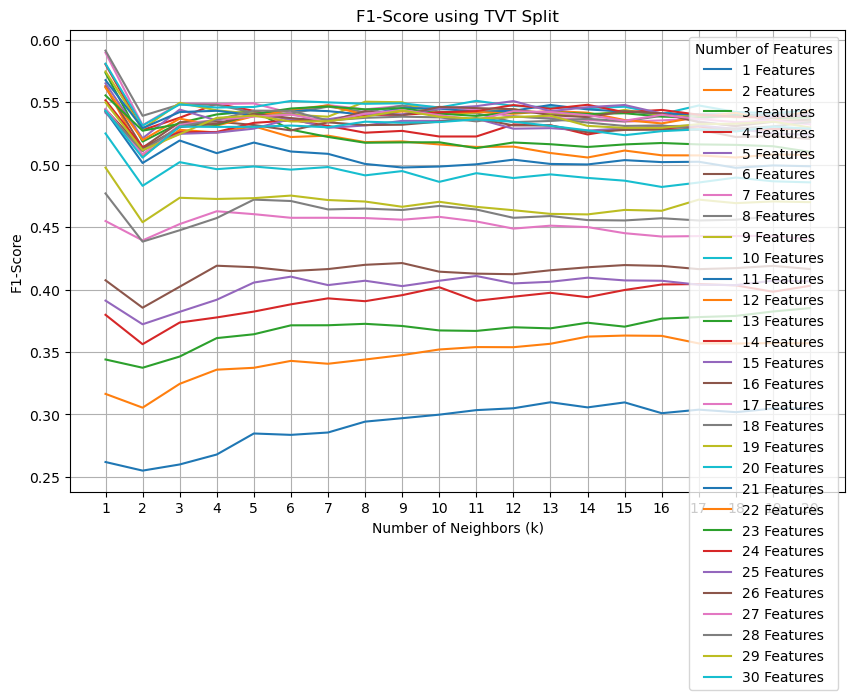

In [90]:
# 2.5. Model Evaluation. Evaluate the model performance on the Validation set, for different numbers of features and neighbors, based on the F1 score.
#     2.5.1.Evaluate the results through a graph representing the F1-score as a function of k, and
#     with separate curves for each number of features considered, as in the example below.

f1_scores_by_features = {}
for n_neighbors, f1_scores in results_tvt.items():
    for n_features, f1_score in enumerate(f1_scores, start=1):
        if n_features not in f1_scores_by_features:
            f1_scores_by_features[n_features] = []
        f1_scores_by_features[n_features].append(f1_score)

# Plot F1-Score as a function of k for different numbers of features
plt.figure(figsize=(10, 6))

# Iterate through each number of features and plot the corresponding F1 scores for different values of k
for n_features, f1_scores in f1_scores_by_features.items():
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, label=f"{n_features} Features")

plt.title("F1-Score using TVT Split")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("F1-Score")
plt.legend(title="Number of Features", loc="upper right")
plt.xticks(range(1, len(f1_scores) + 1))  # Adjust the x-axis to show each value of k
plt.grid(True)
plt.show()


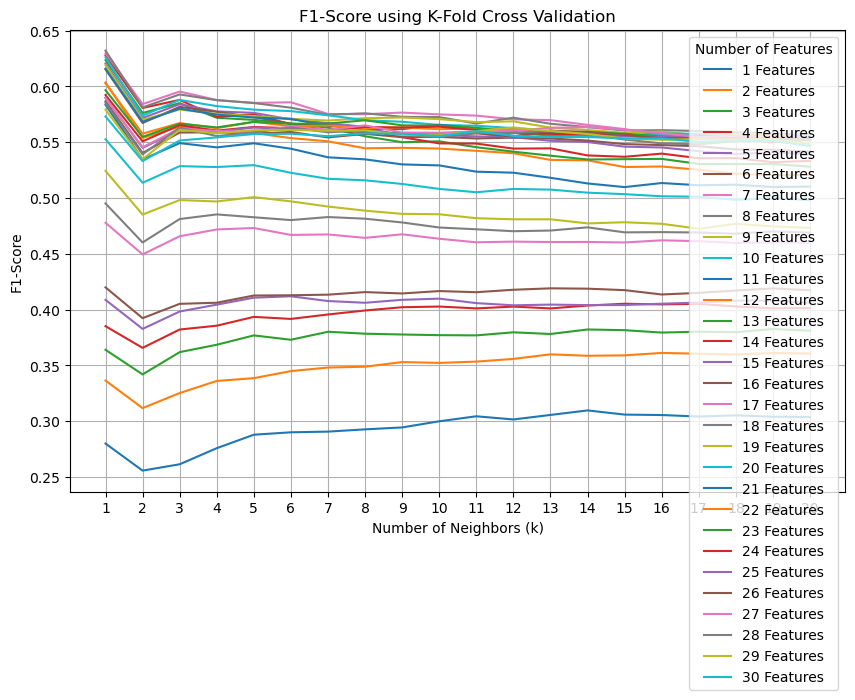

In [91]:
# Do it for K-Fold Cross Validation
f1_scores_by_features_kfold = {}
for n_neighbors, f1_scores in results_kfold.items():
    for n_features, f1_score in enumerate(f1_scores, start=1):
        if n_features not in f1_scores_by_features_kfold:
            f1_scores_by_features_kfold[n_features] = []
        f1_scores_by_features_kfold[n_features].append(f1_score)

# Plot F1-Score as a function of k for different numbers of features
plt.figure(figsize=(10, 6))

# Iterate through each number of features and plot the corresponding F1 scores for different values of k
for n_features, f1_scores in f1_scores_by_features_kfold.items():
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, label=f"{n_features} Features")

plt.title("F1-Score using K-Fold Cross Validation")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("F1-Score")
plt.legend(title="Number of Features", loc="upper right")
plt.xticks(range(1, len(f1_scores) + 1))  # Adjust the x-axis to show each value of k
plt.grid(True)
plt.show()

### NOTE: Since the results are not what I expected (i was expecting something around 0.80 or higher), i decided to test my model with the iris dataset. This were the results:

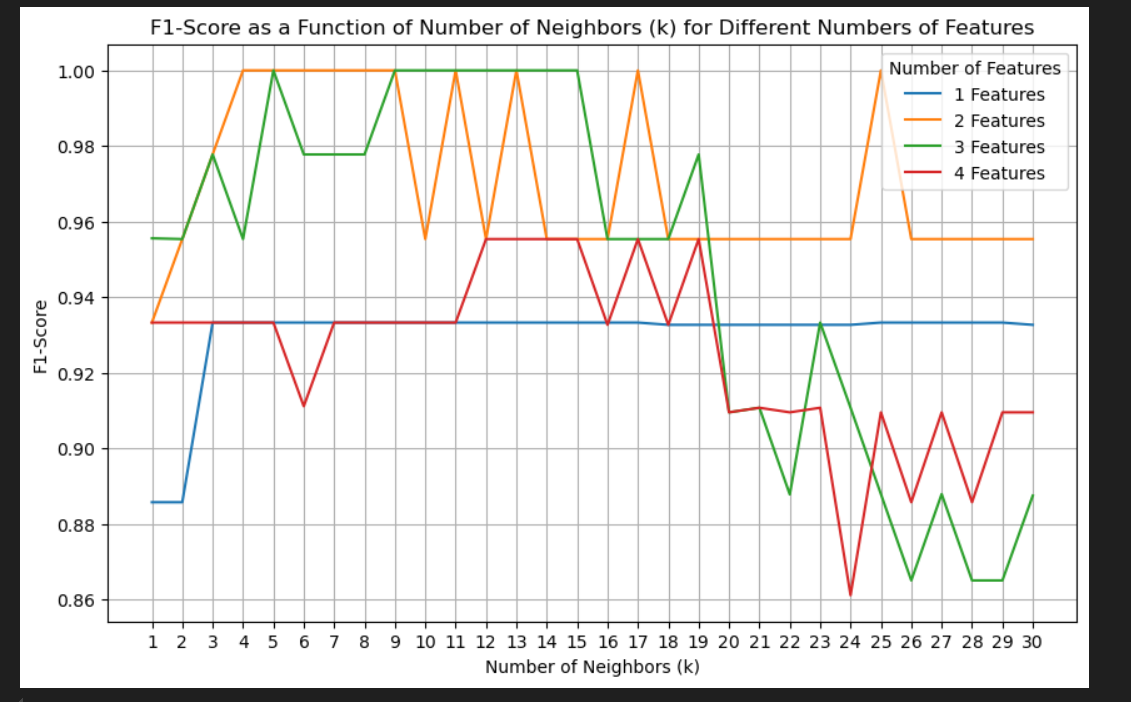


### With this, we can see that the model can reach extremly good results when we use the iris dataset to test it. This makes me conclude that the lower results in the project are due to our dataset, and not the module or some data preparation made to use the model. So, after this fast check, i feel confident to continue the project.

2.5.2. Select the optimal number of features and neighbors.

In [ ]:
# 2.5.2.@ Select the optimal number of features and neighbors.
# get the highest f1 score in the results
best_f1 = 0
best_n_features = 0
best_n_neighbors = 0


for n_neighbors, f1_scores in results_tvt.items():
    if n_neighbors != 1:
        for n_features, f1_score in enumerate(f1_scores, start=1):
            if f1_score > best_f1:
                best_f1 = f1_score
                best_n_features = n_features
                best_n_neighbors = n_neighbors

print(f"Best F1-Score Using TVT Split: {best_f1:.4f}")
print(f"Optimal Number of Features: {best_n_features}")
print(f"Optimal Number of Neighbors: {best_n_neighbors}")

# Do it for K-Fold Cross Validation
best_f1_kfold = 0
best_n_features_kfold = 0
best_n_neighbors_kfold = 0

for n_neighbors, f1_scores in results_kfold.items():
    if n_neighbors != 1:
        for n_features, f1_score in enumerate(f1_scores, start=1):
            if f1_score > best_f1_kfold:
                best_f1_kfold = f1_score
                best_n_features_kfold = n_features
                best_n_neighbors_kfold = n_neighbors

print("\n")
print(f"Best F1-Score using K-Fold Cross Validation: {best_f1_kfold:.4f}")
print(f"Optimal Number of Features: {best_n_features_kfold}")
print(f"Optimal Number of Neighbors: {best_n_neighbors_kfold}")


#print(results[1][16])

Best F1-Score Using TVT Split: 0.5913
Optimal Number of Features: 18
Optimal Number of Neighbors: 1


Best F1-Score using K-Fold Cross Validation: 0.6320
Optimal Number of Features: 18
Optimal Number of Neighbors: 1


#### 2.6. Parameters optimization II. Using the number of features and neighbors identified before, test the effect of other parameter configurations
2.6.1. Evaluate different weight function: uniform and distance weights.

2.6.2. Evaluate diverse distance metrics: Minkowski with p=1 (Manhattan), p=2
(Euclidean) and p=3.

In [95]:
# 2.6. Parameters optimization II. Using the number of features and neighbors identified
# before, test the effect of other parameter configurations
    # 2.6.1. Evaluate different weight function: uniform and distance weights.
    # 2.6.2. Evaluate diverse distance metrics: Minkowski with p=1 (Manhattan), p=2
    # (Euclidean) and p=3.

# Function to train a KNN model with a given number of neighbors, weight function, and distance metric
def trainKNN(X_train, X_val, y_train, n_neighbors=1, weights='uniform', metric='minkowski', p=2):
    # Initialize the KNN model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, p=p)
    
    # Train the model
    knn.fit(X_train, y_train)

    # predict the labels
    y_pred = knn.predict(X_val)
    
    return knn, y_pred

################################################################################ TVT SPLIT #######################################################################################
# Test the effect of different parameter configurations
results_tvt = {}
for weights in ['uniform', 'distance']:
    results_tvt[weights] = {}
    for metric in ['minkowski', 'euclidean', 'manhattan']:
        results_tvt[weights][metric] = {}
        for p in range(1, 4):
            results_tvt[weights][metric][p] = []
            for n_features in range(1, len(X_train_tvt[0]) + 1):
                # Select the top N features
                selected_features = top_features[:n_features]

                # Get the indices of the selected features
                feature_indices = [feature_names.index(feature) for feature in selected_features]

                # Train
                knn, y_pred = trainKNN(X_train_tvt[:, feature_indices], X_val_tvt[:, feature_indices], y_train_tvt, best_n_neighbors, weights, metric, p)

                # Evaluate the model
                y_val_tvt = np.array(y_val_tvt)
                y_pred = np.array(y_pred)
                _, precision, recall, f1 = evaluateModel(y_val_tvt, y_pred, labels)

                # Store the f1 score
                results_tvt[weights][metric][p].append(f1)


In [96]:
################################################################## K-FOLD VALIDATION ############################################################################################

results_kfold = {}
for weights in ['uniform', 'distance']:
    results_kfold[weights] = {}
    for metric in ['minkowski', 'euclidean', 'manhattan']:
        results_kfold[weights][metric] = {}
        for p in range(1, 4):
            results_kfold[weights][metric][p] = []
            for n_features in range(1, len(X_train_tt[0]) + 1):
                # Select the top N features
                selected_features = top_features[:n_features]

                # Get the indices of the selected features
                feature_indices = [feature_names.index(feature) for feature in selected_features]

                # To store F1-scores across folds
                f1_scores_per_fold = []

                # Perform k-fold cross-validation
                for X_train_fold, X_val_fold, y_train_fold, y_val_fold in fold_indices:
                    # Train the model for this fold
                    knn, y_pred = trainKNN(
                        X_train_fold[:, feature_indices], 
                        X_val_fold[:, feature_indices], 
                        y_train_fold, 
                        n_neighbors=best_n_neighbors, 
                        weights=weights, 
                        metric=metric, 
                        p=p
                    )

                    # Evaluate the model for this fold
                    _, precision, recall, f1 = evaluateModel(y_val_fold, y_pred, labels)
                    f1_scores_per_fold.append(f1)

                # Store the average F1-score across folds
                avg_f1_score = np.mean(f1_scores_per_fold)
                results_kfold[weights][metric][p].append(avg_f1_score)



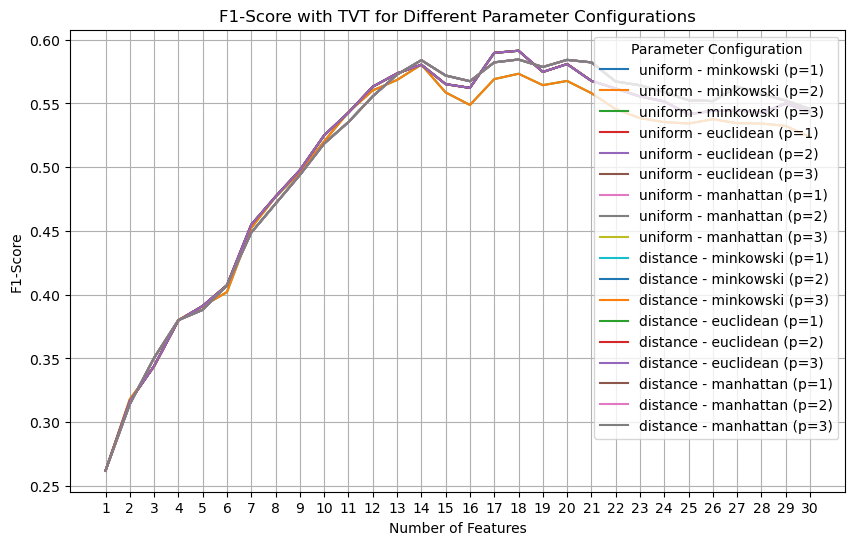

In [97]:
# Plot F1-Score as a function of different parameter configurations
plt.figure(figsize=(10, 6))

# Iterate through each weight function and distance metric
for weights, metrics in results_tvt.items():
    for metric, ps in metrics.items():
        for p, f1_scores in ps.items():
            plt.plot(range(1, len(f1_scores) + 1), f1_scores, label=f"{weights} - {metric} (p={p})")

plt.title("F1-Score with TVT for Different Parameter Configurations")
plt.xlabel("Number of Features")
plt.ylabel("F1-Score")
plt.legend(title="Parameter Configuration", loc="upper right")
plt.xticks(range(1, len(f1_scores) + 1))  # Adjust the x-axis to show each value of k
plt.grid(True)
plt.show()

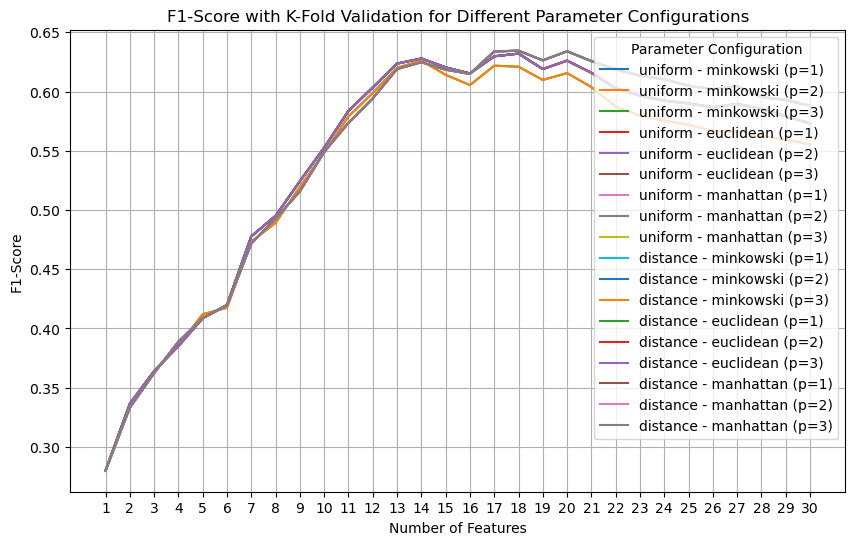

In [98]:
### For K-Fold Validation
# Plot F1-Score as a function of different parameter configurations
plt.figure(figsize=(10, 6))

# Iterate through each weight function and distance metric
for weights, metrics in results_kfold.items():
    for metric, ps in metrics.items():
        for p, f1_scores in ps.items():
            plt.plot(range(1, len(f1_scores) + 1), f1_scores, label=f"{weights} - {metric} (p={p})")

plt.title("F1-Score with K-Fold Validation for Different Parameter Configurations")
plt.xlabel("Number of Features")
plt.ylabel("F1-Score")
plt.legend(title="Parameter Configuration", loc="upper right")
plt.xticks(range(1, len(f1_scores) + 1))  # Adjust the x-axis to show each value of k
plt.grid(True)
plt.show()


#### 2.7. Model Test. Implement a kNN classifier using the train and validation sets.

2.7.1.Use the best configuration of parameters identified in the previous steps.

In [99]:
# get the best parameters
best_f1_score = 0
best_configuration_tvt = {}

# Iterate through the results_kfold dictionary
for weights, metrics in results_tvt.items():
    for metric, ps in metrics.items():
        for p, f1_scores in ps.items():
            for n_features, f1_score in enumerate(f1_scores, start=1):  # start=1 to match feature count
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    best_configuration_tvt = {
                        'weights': weights,
                        'metric': metric,
                        'p': p,
                        'n_features': n_features
                    }

# Print the best configuration and corresponding F1-score
print(f"Best F1-Score With TVT Split: {best_f1_score:.4f}")
print("Best Configuration:")
print(f"  Weighting Function: {best_configuration_tvt['weights']}")
print(f"  Distance Metric: {best_configuration_tvt['metric']}")
print(f"  Minkowski Parameter p: {best_configuration_tvt['p']}")
print(f"  Number of Features: {best_configuration_tvt['n_features']}")

# get the best parameters
best_f1_score = 0
best_configuration_kfold = {}

# Iterate through the results_kfold dictionary
for weights, metrics in results_kfold.items():
    for metric, ps in metrics.items():
        for p, f1_scores in ps.items():
            for n_features, f1_score in enumerate(f1_scores, start=1):  # start=1 to match feature count
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    best_configuration_kfold = {
                        'weights': weights,
                        'metric': metric,
                        'p': p,
                        'n_features': n_features
                    }

# Print the best configuration and corresponding F1-score
print("\n")
print(f"Best F1-Score With K-Fold Validation Split: {best_f1_score:.4f}")
print("Best Configuration:")
print(f"  Weighting Function: {best_configuration_kfold['weights']}")
print(f"  Distance Metric: {best_configuration_kfold['metric']}")
print(f"  Minkowski Parameter p: {best_configuration_kfold['p']}")
print(f"  Number of Features: {best_configuration_kfold['n_features']}")




Best F1-Score With TVT Split: 0.5913
Best Configuration:
  Weighting Function: uniform
  Distance Metric: minkowski
  Minkowski Parameter p: 2
  Number of Features: 18


Best F1-Score With K-Fold Validation Split: 0.6344
Best Configuration:
  Weighting Function: uniform
  Distance Metric: minkowski
  Minkowski Parameter p: 1
  Number of Features: 18


2.7.2.Evaluate the model performance on the Test set.

TVT-SPLIT RESULTS



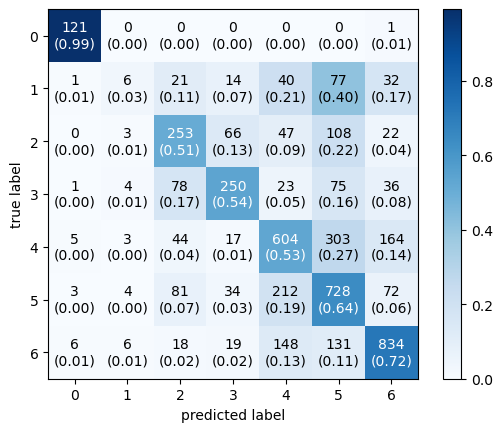

Precision (Test Set): 0.5775
Recall (Test Set): 0.5650
F1-Score (Test Set): 0.5584


In [104]:
# 2.7.2.Evaluate the model performance on the Test set.
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

knn = KNeighborsClassifier(
    n_neighbors=best_configuration_tvt['n_features'],  # Optimal number of neighbors
    weights=best_configuration_tvt['weights'],        # Optimal weights
    metric=best_configuration_tvt['metric'],          # Optimal distance metric
    p=best_configuration_tvt['p']                     # Minkowski parameter
)

X_train_tvt = np.vstack([X_train_tvt, X_val_tvt])
y_train_tvt = np.hstack([y_train_tvt, y_val_tvt])

knn.fit(X_train_tvt, y_train_tvt)

y_pred = knn.predict(X_test_tvt)

# Evaluate the model performance on the test set
matrix, precision, recall, f1 = evaluateModel(y_test_tvt, y_pred, labels)

print("TVT-SPLIT RESULTS\n")
plot_confusion_matrix(matrix,
                      colorbar=True,
                      show_absolute=True,
                      show_normed=True)
plt.show()
# print("Confusion Matrix (Test Set):")
# print(conf_matrix)
# print("\nClassification Report (Test Set):")
# print(classification_report(y_test_tvt, y_pred))

print(f"Precision (Test Set): {precision:.4f}")
print(f"Recall (Test Set): {recall:.4f}")
print(f"F1-Score (Test Set): {f1:.4f}")



K-Fold Validation RESULTS



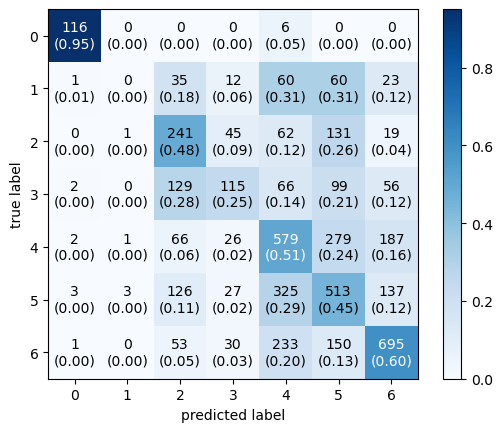

Precision (Test Set): 0.4605
Recall (Test Set): 0.4626
F1-Score (Test Set): 0.4556


In [148]:
# 2.7.2.Evaluate the model performance on the Test set.
knn_kfold = KNeighborsClassifier(
    n_neighbors=best_configuration_kfold['n_features'],  # Optimal number of neighbors
    weights=best_configuration_kfold['weights'],        # Optimal weights
    metric=best_configuration_kfold['metric'],          # Optimal distance metric
    p=best_configuration_kfold['p']                     # Minkowski parameter
)


knn_kfold.fit(X_train_tt, y_train_tt)

y_pred = knn_kfold.predict(X_test_tt)

# Evaluate the model performance on the test set
conf_matrix, precision, recall, f1 = evaluateModel(y_test_tt, y_pred, labels)

print("K-Fold Validation RESULTS\n")

plot_confusion_matrix(conf_matrix,
                      colorbar=True,
                      show_absolute=True,
                      show_normed=True)
plt.show()

# print("Confusion Matrix (Test Set):")
# print(conf_matrix)
# print("\nClassification Report (Test Set):")
# print(classification_report(y_test_tt, y_pred))

print(f"Precision (Test Set): {precision:.4f}")
print(f"Recall (Test Set): {recall:.4f}")
print(f"F1-Score (Test Set): {f1:.4f}")



2.7.3.Evaluate the model performance in the Train set.

TVT-SPLIT RESULTS



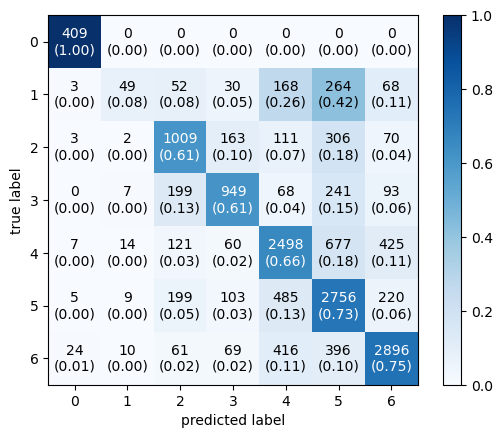

Precision (Training Set): 0.6828
Recall (Training Set): 0.6325
F1-Score (Training Set): 0.6313


In [116]:
# 2.7.3.Evaluate the model performance in the Train set.


# Predict on the training set
y_train_pred = knn.predict(X_train_tvt)

# Evaluate performance on the training set
conf_matrix, precision, recall, f1 = evaluateModel(
    y_train_tvt, y_train_pred, labels
)

print("TVT-SPLIT RESULTS\n")

plot_confusion_matrix(conf_matrix,
                      colorbar=True,
                      show_absolute=True,
                      show_normed=True)
plt.show()

# Print results
# print("Confusion Matrix (Training Set):")
# print(conf_matrix)
# print("\nClassification Report (Training Set):")
# print(classification_report(y_train_tvt, y_train_pred))

print(f"Precision (Training Set): {precision:.4f}")
print(f"Recall (Training Set): {recall:.4f}")
print(f"F1-Score (Training Set): {f1:.4f}")

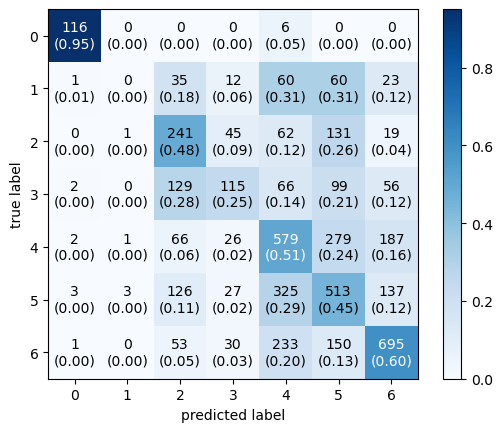

Precision (Training Set): 0.4605
Recall (Training Set): 0.4626
F1-Score (Training Set): 0.4556


In [ ]:
# Predict on the training set
y_train_pred = knn_kfold.predict(X_train_tt)

# Evaluate performance on the training set
conf_matrix, precision, recall, f1 = evaluateModel(
    y_train_tt, y_train_pred, labels
)

# Print results
print("K-Fold Validation RESULTS\n")

plot_confusion_matrix(conf_matrix,
                      colorbar=True,
                      show_absolute=True,
                      show_normed=True)
plt.show()

# print("Confusion Matrix (Training Set):")
# print(conf_matrix)
# print("\nClassification Report (Training Set):")
# print(classification_report(y_train_tt, y_train_pred))

print(f"Precision (Training Set): {precision:.4f}")
print(f"Recall (Training Set): {recall:.4f}")
print(f"F1-Score (Training Set): {f1:.4f}")

2.7.4. Compare the results from 2.7.2 and 2.7.3 and analyze in terms of underfittingoverfitting

The F1-Score is low when we use the test set to evaluate, but when we evaluate with the training set it increases a lot. This means that our model is performing better and is better identifying all relevant instance in the training data compared to the test data .This discrepancy can indicate that the model generalizes less effectively on unseen data.

Overfitting: This performance difference suggests that the model might be overfitting to the training data. Overfitting is when a model learns the training data too well, capturing details or noise that don't generalize to new data (or all data).

Underfitting: Since the training set performance is reasonably high, we can rule out significat underfitting. Underfitting occurs if the model fails to capture sufficient patterns even in the training data (but a f1-score of 0.65 is already quite high).

## 3. Neural network classifier: Multilayer Perceptron (MLP).
#### 3.1. Implement a MLP classifier. Use the following specifications:

3.1.1.TVT splitting and batch learning

In [ ]:
# 3.1.1.TVT splitting and batch learning

## TVT SPLITTING AND NORMALIZE
X_train, X_val, X_test, y_train, y_val, y_test = TVT_Split(feature_data, classes)
X_train, mean, std = normalize(X_train)
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# batch learning: Teacher said to do this (???)
batch_size = len(X_train)

3.1.2.Select the optimal number of features.
###### 3.1.2.1. Implement a MLP with one hidden layer, and a number of neurons in the hidden layer equal to the number of outputs (classes).
###### 3.1.2.2. Use the ‘lbfgs’ solver and set the remaining parameters as default.
###### 3.1.2.3. Vary the number of features and evaluate the performance on the Validation set.

In [ ]:
# 3.1.2.Select the optimal number of features.
# 3.1.2.1. Implement a MLP with one hidden layer, and a number of neurons in the
# hidden layer equal to the number of outputs (classes).
# 3.1.2.2. Use the ‘lbfgs’ solver and set the remaining parameters as default.
# 3.1.2.3. Vary the number of features and evaluate the performance on the
# Validation set.
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning
# Ignore warning to have a more readable pdf
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


from sklearn.neural_network import MLPClassifier

results = []

# Lets get the number of classes
n_classes = len(np.unique(y_train))

for n_features in range(1, len(X_train[0]) + 1):
    # Select the n top features
    selected_features = top_features[:n_features]
    feature_indices = [feature_names.index(feature) for feature in selected_features]

    # Filter with our number of features the size of the sets we will use
    X_train_selected = X_train[:, feature_indices]
    X_val_selected = X_val[:, feature_indices]

    # Configure our MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=(n_classes,),  # Nº Neurons = Nº Classes 3.1.2.1
        solver="lbfgs",  # Solver Like specified
        batch_size=batch_size,  # batch learning????? (MAS LBFGS Doesnt Use BATCH SIZE???)
        random_state=42,  # Results reprodutable 
        max_iter=200
    )

    # Train the model
    mlp.fit(X_train_selected, y_train)

    # Test it in the validation set
    y_pred = mlp.predict(X_val_selected)

    conf_matrix, precision, recall, f1 = evaluateModel(y_val, y_pred, labels)

    # Store results to analyze later
    results.append({
        "n_features": n_features,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    })



Best configuration:
Number of features: 19
Precision: 0.6224
Recall: 0.5910
F1-Score: 0.5834


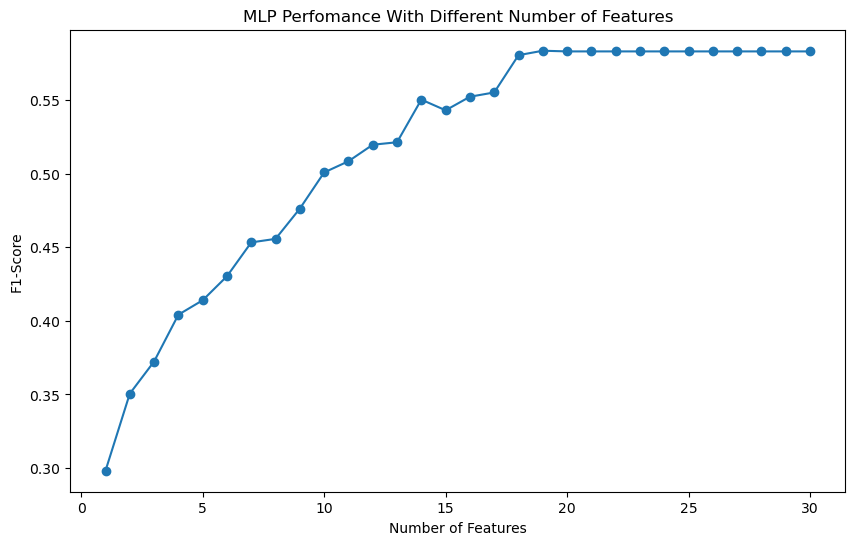

In [ ]:
# Sorte by F1-Score
best_result = max(results, key=lambda x: x["f1_score"])

best_n_features = best_result['n_features']

# Best Results
print("Best configuration:")
print(f"Number of features: {best_result['n_features']}")
print(f"Precision: {best_result['precision']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")
print(f"F1-Score: {best_result['f1_score']:.4f}")

# Lets plot it
n_features = [r["n_features"] for r in results]
f1_scores = [r["f1_score"] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(n_features, f1_scores, marker='o')
plt.title("MLP Perfomance With Different Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("F1-Score")
plt.show()

3.1.3.Select the optimal parameters configuration.
###### 3.1.3.1. Implement a MLP using the optimal number of features identified in 3.1.2.
###### 3.1.3.2. Use the ‘lbfgs’ solver and constant learning rate.
###### 3.1.3.3. Implement MLPs with one and two hidden layers, and a variable number of neurons in the hidden layers.
###### 3.1.3.4. Evaluate (on the Validation set) the results through a graph representing the F1-score as function of the number of neurons in the hidden layer, and with separate curves for the MLPs with one and two hidden layers.
###### 3.1.3.5. Select the best number of hidden layers and neurons.
###### 3.1.3.6. With the optimal parameters identified before, systematically evaluate (in the Validation set) de effect of varying other model parameters, as: activation functions in the hidden layer, solver, learning rate and maximum iterations.

In [ ]:
# 3.1.3.Select the optimal parameters configuration.
    # 3.1.3.1. Implement a MLP using the optimal number of features identified in 3.1.2.
    # 3.1.3.2. Use the ‘lbfgs’ solver and constant learning rate.
    # 3.1.3.3. Implement MLPs with one and two hidden layers, and a variable number
    # of neurons in the hidden layers.
    # 3.1.3.4. Evaluate (on the Validation set) the results through a graph representing
    # the F1-score as function of the number of neurons in the hidden layer, and with
    # separate curves for the MLPs with one and two hidden layers.
    # 3.1.3.5. Select the best number of hidden layers and neurons.
    # 3.1.3.6. With the optimal parameters identified before, systematically evaluate (in
    # the Validation set) de effect of varying other model parameters, as: activation
    # functions in the hidden layer, solver, learning rate and maximum iterations.


# Ignore warning to have a more readable pdf
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 3.1.3.1
n_features = best_n_features
top_features = list(all_features_by_score_fisher.keys())[:n_features]
feature_indices = [feature_names.index(feature) for feature in top_features]
X_train_optimal = X_train[:, feature_indices]
X_val_optimal = X_val[:, feature_indices]

# Store results de 3.1.3.3
results = {"one_layer": [], "two_layers": []}
neurons_range = range(1, 61)  # Vairate the Nº of neurons from 1 to 60

# 3.1.3.3 - Implement MLPs with one and two hidden layers, and a variable number
# of neurons in the hidden layers.
for n_neurons in neurons_range:
    # Uma camada oculta
    mlp_one_layer = MLPClassifier(
        hidden_layer_sizes=(n_neurons,),
        solver="lbfgs",             # 3.1.3.2
        learning_rate="constant",   # 3.1.3.2 ??? Why do we do this if lbfgs doesnt use lerning_rate? Only sgd does.
        random_state=42
    )
    mlp_one_layer.fit(X_train_optimal, y_train)

    y_val_pred_one = mlp_one_layer.predict(X_val_optimal)

    _, _, _, f1 = evaluateModel(y_val, y_val_pred_one, labels)
    results["one_layer"].append(f1)

    # Now with two hidden layers
    mlp_two_layers = MLPClassifier(
        hidden_layer_sizes=(n_neurons, n_neurons),
        solver="lbfgs",
        learning_rate="constant",
        random_state=42
    )
    mlp_two_layers.fit(X_train_optimal, y_train)

    y_val_pred_two = mlp_two_layers.predict(X_val_optimal)
    _, _, _, f1 = evaluateModel(y_val, y_val_pred_two, labels)
    results["two_layers"].append(f1)

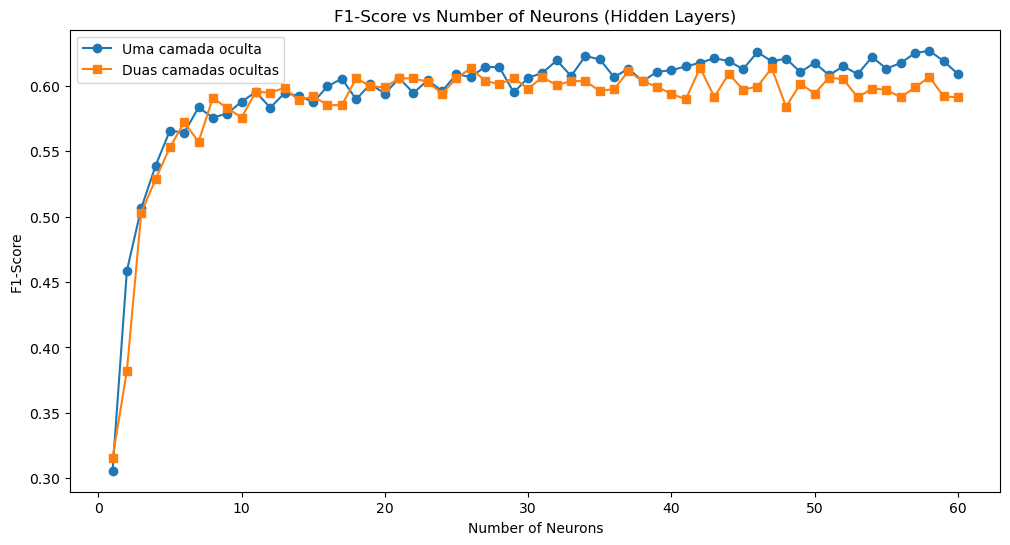

Best configuration:
Nº Hidden Layers: 1
Nº Neurons: 58
F1-Score: 0.6267


In [ ]:
# 3.1.3.4 - F1-Score for different number of neurons
plt.figure(figsize=(12, 6))
plt.plot(neurons_range, results["one_layer"], label="Uma camada oculta", marker="o")
plt.plot(neurons_range, results["two_layers"], label="Duas camadas ocultas", marker="s")
plt.title("F1-Score vs Number of Neurons (Hidden Layers)")
plt.xlabel("Number of Neurons")
plt.ylabel("F1-Score")
plt.legend()
plt.show()

# 3.1.3.5 - Select the best parameters
best_one_layer = max(results["one_layer"])
best_two_layers = max(results["two_layers"])

if best_one_layer > best_two_layers:
    best_config = {
        "layers": 1,
        "neurons": results["one_layer"].index(best_one_layer) + 1,
        "f1_score": best_one_layer
    }
else:
    best_config = {
        "layers": 2,
        "neurons": results["two_layers"].index(best_two_layers) + 1,
        "f1_score": best_two_layers
    }

best_n_layers = best_config['layers']
best_n_neurons = best_config['neurons']

print("Best configuration:")
print(f"Nº Hidden Layers: {best_config['layers']}")
print(f"Nº Neurons: {best_config['neurons']}")
print(f"F1-Score: {best_config['f1_score']:.4f}")

In [ ]:
# 3.1.3.6. With the optimal parameters identified before, systematically evaluate (in
# the Validation set) de effect of varying other model parameters, as: activation
# functions in the hidden layer, solver, learning rate and maximum iterations.
from tqdm import tqdm

# Ignore warning to have a more readable pdf
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

n_features = best_n_features
n_layers = best_n_layers
n_neurons = best_n_neurons

# Parameters to vary
activation_functions = ['identity', 'logistic', 'tanh', 'relu']
solvers = ['lbfgs', 'sgd', 'adam']
learning_rates = ['constant', 'invscaling', 'adaptive']
max_iterations = [100, 200, 500]

# I DECIDED TO NOT USE THIS
# batches = [2, 4, 8, 16, 32]


# Results dictionary to store performance metrics
results_param_variation = {}

# Select the optimal features
top_features = list(all_features_by_score_fisher.keys())[:n_features]
feature_indices = [feature_names.index(feature) for feature in top_features]
X_train_optimal = X_train[:, feature_indices]
X_val_optimal = X_val[:, feature_indices]

# Loop through all combinations of parameters
for activation in tqdm(activation_functions):
    for solver in solvers:
        for learning_rate in learning_rates:
            for max_iter in max_iterations:
                
                # Only sgd uses learning_rates
                if solver != "sgd" and learning_rate != 'constant':
                    continue


                # Initialize the MLP with current parameters
                mlp = MLPClassifier(
                    hidden_layer_sizes=(n_neurons,) * n_layers,
                    activation=activation,
                    solver=solver,
                    learning_rate=learning_rate,
                    max_iter=max_iter,
                    batch_size=batch_size,
                    random_state=42
                )
                    
                try:
                    # Train the model
                    mlp.fit(X_train_optimal, y_train)
                        
                    # Predict on validation set
                    y_val_pred = mlp.predict(X_val_optimal)
                        
                    # Evaluate performance
                    _, _, _, f1 = evaluateModel(y_val, y_val_pred, labels)
                        
                    # Store results
                    key = (activation, solver, learning_rate, max_iter)
                    results_param_variation[key] = f1
                except Exception as e:
                    # Handle potential errors (e.g., convergence issues)
                    print(f"Error with parameters {key}: {e}")
                    results_param_variation[key] = None

100%|██████████| 4/4 [02:26<00:00, 36.54s/it]



Best Parameter Configuration:
Activation Function: relu
Solver: lbfgs
Learning Rate: constant
Max Iterations: 200
Best F1-Score: 0.6267


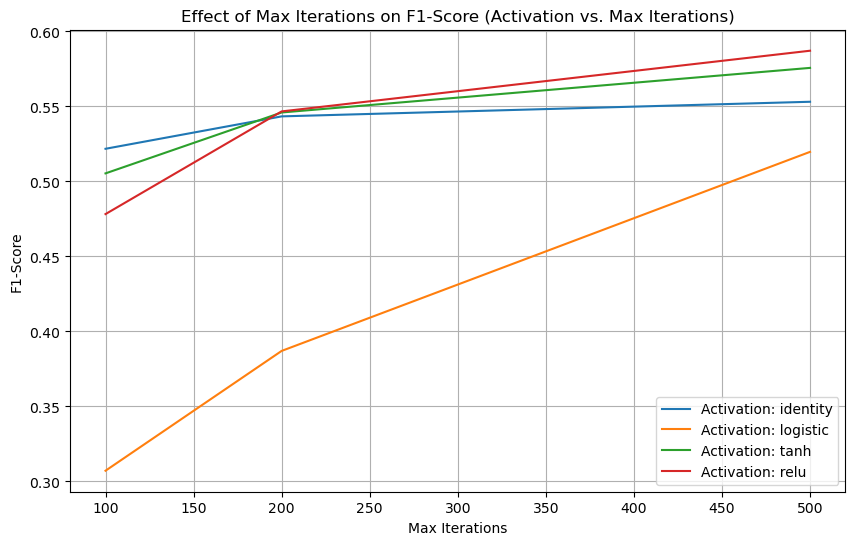

In [196]:
# Find the best configuration
best_params = max(results_param_variation, key=results_param_variation.get)
best_f1 = results_param_variation[best_params]

best_activation_function = best_params[0]
best_solver = best_params[1]
best_learning_rate = best_params[2]
best_max_iter = best_params[3]

# Print the best results
print("\nBest Parameter Configuration:")
print(f"Activation Function: {best_params[0]}")
print(f"Solver: {best_params[1]}")
print(f"Learning Rate: {best_params[2]}")
print(f"Max Iterations: {best_params[3]}")
print(f"Best F1-Score: {best_f1:.4f}")

# Optional: Plot the F1-Score for different parameter configurations (example: varying max_iter)
plt.figure(figsize=(10, 6))
for activation in activation_functions:
    scores = [results_param_variation.get((activation, 'adam', 'constant', it), 0) for it in max_iterations]
    plt.plot(max_iterations, scores, label=f"Activation: {activation}")

plt.title("Effect of Max Iterations on F1-Score (Activation vs. Max Iterations)")
plt.xlabel("Max Iterations")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True)
plt.show()


#### 3.2. Model Test. After identifying the optimal parameters, train the MLP classifier using the train and validation sets.
3.2.1.Evaluate the model performance on the test set.

3.2.2.Evaluate the model performance on the training set.


In [ ]:
# 3.2. Model Test. After identifying the optimal parameters, train the MLP classifier using the
# train and validation sets.
# 3.2.1.Evaluate the model performance on the test set.
from sklearn.neural_network import MLPClassifier

# Ignore warning to have a more readable pdf
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

n_features = best_n_features
hidden_layers = best_n_layers
n_neurons = best_n_neurons
max_iter = best_max_iter
solver = best_solver
activation_function = best_activation_function
learning_rate = best_learning_rate

# Combine Train and Validation sets
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])

# Select the top features based on previous analysis
top_features = list(all_features_by_score_fisher.keys())[:n_features]
feature_indices = [feature_names.index(feature) for feature in top_features]
print(feature_indices)
X_train_val_optimal = X_train_val[:, feature_indices]
X_test_optimal = X_test[:, feature_indices]

# Initialize the MLP with the optimal parameters
mlp = MLPClassifier(
    hidden_layer_sizes=(n_neurons,) * hidden_layers,
    activation=activation_function,
    solver=solver,
    learning_rate=learning_rate,
    max_iter=max_iter,
    random_state=42
)

# Train the MLP using the train and validation sets
mlp.fit(X_train_val_optimal, y_train_val)

# Predict on the test set
y_test_pred = mlp.predict(X_test_optimal)



[16, 15, 1, 10, 0, 12, 3, 8, 7, 6, 5, 9, 4, 14, 17, 18, 2, 13, 23]


In [ ]:
print(set(y_train_val)) # Nothing to see here, just making sure of something :)

{'right', 'stop', 'forward', 'backward', '_silence_', '_unknown_', 'left'}


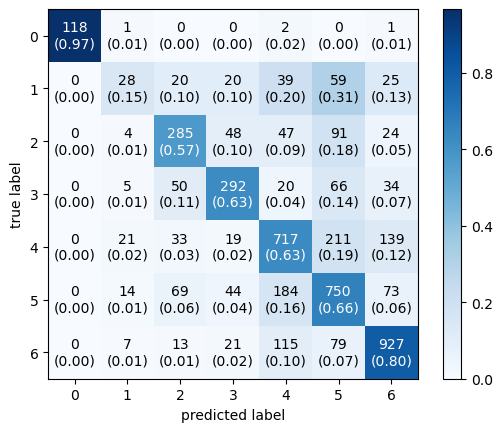

Precision (Test Set): 0.6581
Recall (Test Set): 0.6283
F1-Score (Test Set): 0.6368


In [199]:
# Evaluate performance on the test set
conf_matrix, precision, recall, f1 = evaluateModel(y_test, y_test_pred, labels)

# Print results

plot_confusion_matrix(conf_matrix,
                      colorbar=True,
                      show_absolute=True,
                      show_normed=True)
plt.show()
# print("Confusion Matrix (Test Set):")
# print(conf_matrix)


print(f"Precision (Test Set): {precision:.4f}")
print(f"Recall (Test Set): {recall:.4f}")
print(f"F1-Score (Test Set): {f1:.4f}")

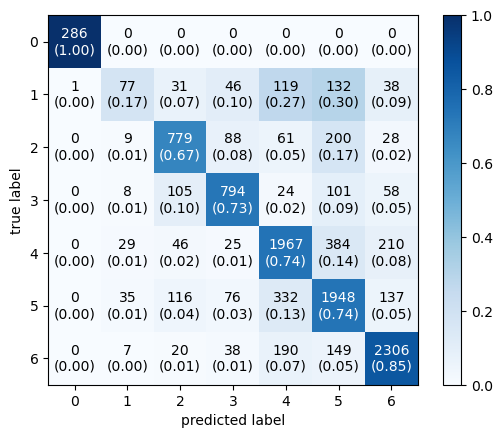

Precision (Training Set): 0.7352
Recall (Training Set): 0.6996
F1-Score (Training Set): 0.7075


In [200]:
# 3.2.2.Evaluate the model performance on the training set.

# Predict on the training set
y_train_val_pred = mlp.predict(X_train_val_optimal)

# Evaluate performance on the training set
conf_matrix_train, precision_train, recall_train, f1_train = evaluateModel(y_train_val, y_train_val_pred, labels)

# Print results
# print("Confusion Matrix (Training Set):")
# print(conf_matrix_train)

plot_confusion_matrix(conf_matrix_train,
                      colorbar=True,
                      show_absolute=True,
                      show_normed=True)
plt.show()

print(f"Precision (Training Set): {precision_train:.4f}")
print(f"Recall (Training Set): {recall_train:.4f}")
print(f"F1-Score (Training Set): {f1_train:.4f}")


In [201]:
import pickle 

print(all_features_by_score_fisher.keys())

array = all_features_by_score_fisher.keys()

array = list(array)

pickle.dump(mlp, open('classifier.pkl', 'wb'))
pickle.dump(array, open('features.pkl', 'wb'))
pickle.dump((std, mean),  open('std_mean.pkl', 'wb'))


dict_keys(['Spectral Bandwidth', 'Spectral Centroid', 'MFCC 2', 'MFCC 11', 'MFCC 1', 'MFCC 13', 'MFCC 4', 'MFCC 9', 'MFCC 8', 'MFCC 7', 'MFCC 6', 'MFCC 10', 'MFCC 5', 'Energy Entropy', 'MFCC Delta 1', 'MFCC Delta 2', 'MFCC 3', 'RMS Energy', 'MFCC Delta 7', 'MFCC 12', 'MFCC Delta 8', 'MFCC Delta 11', 'MFCC Delta 3', 'MFCC Delta 10', 'MFCC Delta 9', 'MFCC Delta 5', 'MFCC Delta 4', 'MFCC Delta 6', 'MFCC Delta 12', 'MFCC Delta 13'])


3.2.3.Compare the results from 3.2.1 and 3.2.2 and analyze them in terms of underfittingoverfitting.

As for the reults:
1. Confusion Matrix:
    - Training set: the confusion matrix shows that the model performs better, with more accurate classifications and fewer misclassifications across all classes.
    - Test set: there are more significant errors and misclassifications, particularly in classes that are not that represented. 

2. Precision:
    - Test set: 0.64
    - Training set: 0.75
    - As we can see, the precision is bigger when using training instead of the test set. This indicates that the model is better at havinf fewer false positives with training but it gets worse when trying generalizing on unseen data (test data).

3. Recall:
    - Test set: 0.63
    - Training set: 0.71
    - Recall as the same effect as precision (higher in training set), suggesting that the model is better at minimizing false negatives with the training set.

4. F1-Score: 
    - Test set: 0.63
    - Training set: 0.69

5. Underfitting and Overfitting
    - This results show that the model achieves better results on the training sets.
    - This can suggest that the model has learned the training set well, but maybe is a risk of overfitting
    - In fact, the drop of performance on the test set may mean that the model has difficulties to generalize unseen data
    - This may suggest some level of overfitting, where the model is capturing irrelevant patterns or noise from the training data.
    - However, since the gap is small, i want to believe that the overfitting, if indeed present, is not that big

#### 3.3. Analyze the advantages and disadvantages of the kNN and MLP classifiers in terms of performance, generalization, computational demands, etc.

1. Performance
- Comparing the results from the previous exercises, we see that kNN achieves 0.56 as the best f1-score, while MLP achieved 0.63. This makes me conclude that, at least in our case, MLP has a slight better performance. This probably has to do because MLP is a function algorithm, which means it is highly flexible and capable of learning complex, non-linear concepts. This makes me conclude that probably my dataset has sound features where relationships are not that straightforward.
2. Generalization
- To analyze and compare the two classifiers in terms of generalization, we must check Bias-variance Tradeoff (look at the performance differences when using the training or the test set)
- If we go back to the previous exercises, we see that, when using kNN, the f1-score increases from 0.56 to 0.63 when we change from testing with the test data to the training data, making it a 0.07 gap. With MLP the increase is from 0.63 to 0.69, making it a 0.06 gap (NOTE: This values might change when running the code (aka training the models) again). As we can see, both models have similar gaps. So, being the gaps similar, we can conclude that MLP has better generalization since it outperforms kNN on the test set, proving that its better in capturing the patterns in the data while maintaining generalization.
3. Computational demands
- In this project we can see, as to be expected, that kNN as bigger overall computational demands than MLP:
    - kNN has no training time since is a lazy learner. However, it then has a high computational cost during prediction, because it needs to calculate distances to all training points (thats a lot of distances). Its obviously not scalable to large datasets. It also as high memory requirements since we need to store the entire training dataset.
    - As for MLP, despite being more computationally expensive in the training of the model due to backpropagation and etc, having longer training times, its prediction time is very fast once trainned since predictions involves just simple matrix multiplications and activation functions computations. The required memory is also lower since we only store the weights, biases, and intermediate activations and not the entire dataset

4. Others
- We could say that its easier to understand how kNN works than MLP. MLP functions operate more like a black box.
- As we seen before, kNN is not scalable for bigger datasets but MLP is. 


## 4. Custom Neural Network Implementation
Develop a basic neural network from scratch, using one hidden layer and the optimal number
of features and neurons in the hidden layer previously identified. Implement backpropagation
for parameter adjustment, following the Guide to building neural networks from scratch.

In [202]:
#4. Custom Neural Network Implementation
# Develop a basic neural network from scratch, using one hidden layer and the optimal number
# of features and neurons in the hidden layer previously identified. Implement backpropagation
# for parameter adjustment, following the Guide to building neural networks from scratch.

# SLIDES 36-50
# Usar train-test.
# definir o numero de interações que vamos fazer em feedforward e backprop para treinar
#  usar a função feetoforward para avaliar os resultados.
# não esperar grandes resultados

# Ignorar os warnings para não encher o pdf
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


# Implementation of the two missing functions

# Activation function
def sigmoid(t):
    return 1/(1+np.exp(-t))

# Derivative of sigmoid
def sigmoid_derivative(p):
    return p * (1 - p)

# Class definition
class NeuralNetwork:
    def __init__(self, x,y, hidden_nodes=4):
        self.input = x
        self.weights1= np.random.rand(self.input.shape[1],hidden_nodes) # we change this because our nodes will be 30
        self.weights2 = np.random.rand(hidden_nodes,y.shape[1])
        self.y = y
        self.output = np. zeros(y.shape)
        
    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2))
        return self.layer2
        
    def backprop(self):
        d_weights2 = np.dot(self.layer1.T, 2*(self.y -self.output)*sigmoid_derivative(self.output))
        d_weights1 = np.dot(self.input.T, np.dot(2*(self.y -self.output)*sigmoid_derivative(self.output), self.weights2.T)*sigmoid_derivative(self.layer1))
    
        self.weights1 += d_weights1
        self.weights2 += d_weights2

    def train(self, X, y, epochs=1500, log_interval=100):
        for i in range(epochs):
            self.output = self.feedforward()
            self.backprop()
            
            if i % log_interval == 0:
                loss = np.mean(np.square(y - self.output))  # Mean squared loss
                print(f"Iteration {i}, Loss: {loss:.4f}")


# Prepare the data
X_train_tt, X_test_tt, y_train_tt, y_test_tt = TT_Split(feature_data, classes)

X_train_tt = np.array(X_train_tt)
X_test_tt = np.array(X_test_tt)

# Best n_features
n_features = 23
top_features = list(all_features_by_score_fisher.keys())[:n_features]
feature_indices = [feature_names.index(feature) for feature in top_features]

X_train_optimal = X_train_tt[:, feature_indices]
X_test_optimal = X_test_tt[:, feature_indices]

# Normalize
X_train_normalized, mean_train, std_train = normalize(X_train_optimal)
X_test_normalized = (X_test_optimal - mean_train) / std_train


from sklearn.preprocessing import OneHotEncoder

y_train_tt = np.array(y_train_tt)
y_test_tt = np.array(y_test_tt)

# One-Hot Encoding
encoder = OneHotEncoder()
y_train_onehot = encoder.fit_transform(y_train_tt.reshape(-1, 1)).toarray()
y_test_onehot = encoder.transform(y_test_tt.reshape(-1, 1)).toarray()

# train it
hidden_nodes = 60  # number of neurons
NN = NeuralNetwork(X_train_normalized, y_train_onehot, hidden_nodes=hidden_nodes)
NN.train(X_train_normalized, y_train_onehot, epochs=1500, log_interval=100)







Iteration 0, Loss: 0.7688


C:\Users\PC\AppData\Local\Temp\ipykernel_3808\2123079791.py:21: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))


Iteration 100, Loss: 0.1411
Iteration 200, Loss: 0.1397
Iteration 300, Loss: 0.1396
Iteration 400, Loss: 0.1395
Iteration 500, Loss: 0.1402
Iteration 600, Loss: 0.1404
Iteration 700, Loss: 0.1403
Iteration 800, Loss: 0.1403
Iteration 900, Loss: 0.1403
Iteration 1000, Loss: 0.1403
Iteration 1100, Loss: 0.1403
Iteration 1200, Loss: 0.1403
Iteration 1300, Loss: 0.1403
Iteration 1400, Loss: 0.1403


In [203]:
from sklearn.metrics import confusion_matrix, classification_report

# Ignorar os warnings para não encher o pdf
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Evaluate the model on the test data
NN.input = X_test_normalized
y_test_pred_classes = np.argmax(NN.feedforward(), axis=1)

# Convert true labels to integer if they are in one-hot encoding
y_test_true_classes = np.argmax(y_test_onehot, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Generate a classification report
report = classification_report(y_test_true_classes, y_test_pred_classes)

# Print the results
print("Confusion Matrix (Test Set):")
print(conf_matrix)

print("\nClassification Report (Test Set):")
print(report)




Confusion Matrix (Test Set):
[[109   5   2   0   3   3   0]
 [ 67  18  31   0  38  37   0]
 [ 81  95  32   0 236  53   2]
 [ 84 111  28   0 210  34   0]
 [441 119 247   0 112 221   0]
 [348  97 195   0 168 323   3]
 [472 223 252   0 124  91   0]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.07      0.89      0.13       122
           1       0.03      0.09      0.04       191
           2       0.04      0.06      0.05       499
           3       0.00      0.00      0.00       467
           4       0.13      0.10      0.11      1140
           5       0.42      0.28      0.34      1134
           6       0.00      0.00      0.00      1162

    accuracy                           0.13      4715
   macro avg       0.10      0.20      0.10      4715
weighted avg       0.14      0.13      0.12      4715



C:\Users\PC\AppData\Local\Temp\ipykernel_3808\2123079791.py:21: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))
